## Imports

In [3]:
### --- MAIN LIBRARIES --- ###

import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown

In [4]:
!pip install geoplot
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz
!pip install pyvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64

In [35]:
### --- GEO LIBRARIES --- ###

import geopandas as gpd
import geoplot as gplt
import plotly.graph_objects as go
import networkx as nx
import pygraphviz
from pyvis.network import Network

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
import cartopy.io.shapereader as shapereader

# Main

In [ ]:
os.makedirs('./img', exist_ok=True)

def fig_save(figure, filename) -> None:
    figure.savefig(
        filename,
        dpi=300,
        bbox_inches='tight',
        facecolor='white'
    )

### Part 1

category,geo,EU,Not EU,General
1,DE,4.409114,7.699874,12.108988
2,ES,1.724292,4.777990,6.502282
3,FR,1.576915,4.451597,6.028512
4,IT,1.389640,3.864018,5.253658
0,AT,0.901726,0.883155,1.784881


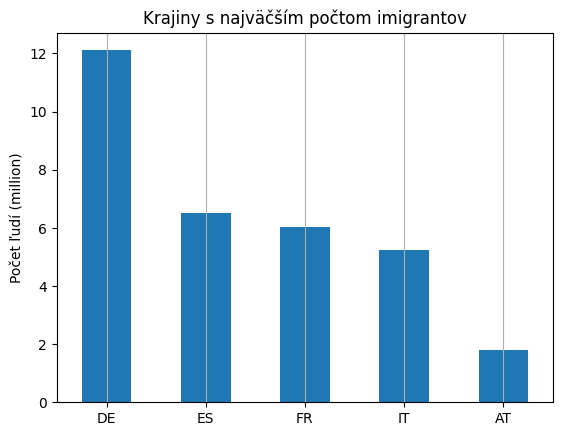

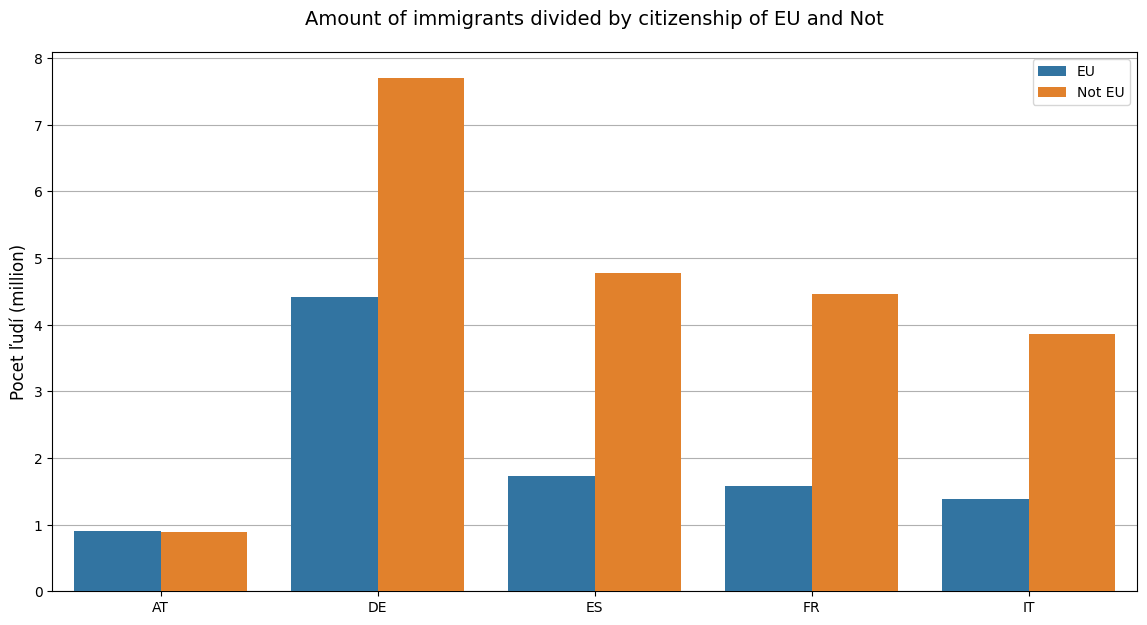

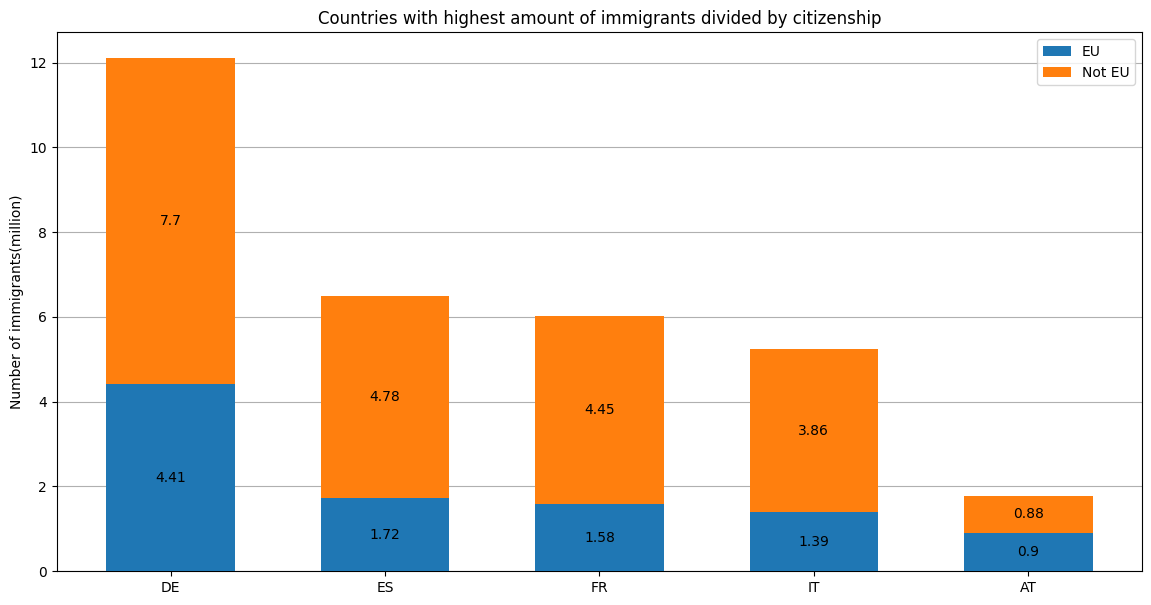

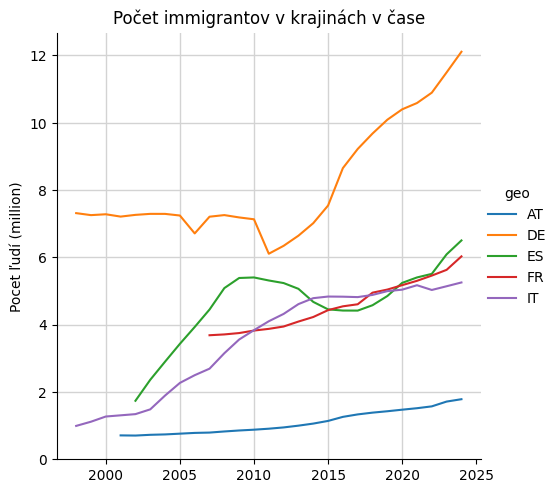

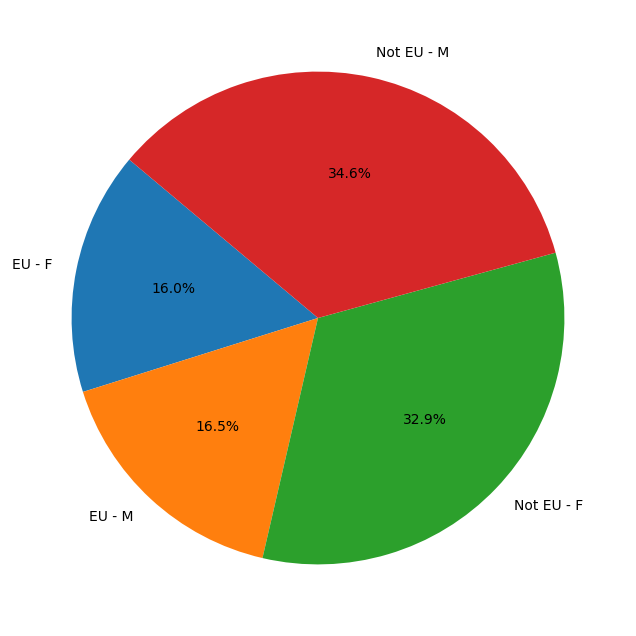

In [6]:
url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/GeneralEU1.csv"
urlEUandNot = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/MigratesFromEUandNot.csv"
urlEUandNot_and_sex = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/MigratesFromEUandNot_and_sex.csv"
df = pd.read_csv(url).drop(['STRUCTURE','STRUCTURE_ID', 'CONF_STATUS', 'OBS_FLAG', 'freq'], axis=1)

# ДатаФрейм без разделения полов
df_without_genders = (df.groupby(['geo', 'TIME_PERIOD'])['OBS_VALUE']
                      .sum()
                      .reset_index()
                      .assign(OBS_VALUE_milion = lambda df: df['OBS_VALUE']/ 1000000))


# ДатаФрейм отсортированный по кол-ву людей по убыванию
df_sorted_by_number_immigrates = df_without_genders[df_without_genders['TIME_PERIOD'] == 2024].sort_values(by="OBS_VALUE", ascending=False)
# Список, который содержит 5 стран с наибольшим кол-вом людей
countries_highest_number_immigrates = list(df_sorted_by_number_immigrates['geo'][:5])
# График людей 5 стран с наибольшим кол-вом людей за 2024 год
plot_for_number_immigrates = df_sorted_by_number_immigrates[:5].plot(x='geo',
                                                                     y='OBS_VALUE_milion',
                                                                     kind='bar',
                                                                     ylabel='Počet ľudí (million)',
                                                                     xlabel='',
                                                                     title='Krajiny s najväčším počtom imigrantov',
                                                                     legend=False)
plot_for_number_immigrates.set_xticklabels(df_sorted_by_number_immigrates[:5]['geo'], rotation=0)
plot_for_number_immigrates.grid(axis='x')

# График людей 5 стран с наибольшим кол-вом людей за 2024 год разделенный по ЕУ и нет
df2 = pd.read_csv(urlEUandNot).drop(['STRUCTURE','STRUCTURE_ID', 'CONF_STATUS', 'OBS_FLAG', 'freq', 'TIME_PERIOD'], axis=1)
df2['OBS_VALUE_milion'] = df2['OBS_VALUE'] /1000000
df_eu = df2.query('citizen=="EU27_2020_FOR"')
df_total = df2.query('citizen=="FOR_STLS"')
merged = pd.merge(
    df_total[['geo', 'OBS_VALUE_milion']],
    df_eu[['geo', 'OBS_VALUE_milion']],
    on=['geo'],
    suffixes=('_total', '_eu')
)
merged['OBS_VALUE_milion_not_eu'] = merged['OBS_VALUE_milion_total'] - merged['OBS_VALUE_milion_eu']
df_not_eu = merged[['geo', 'OBS_VALUE_milion_not_eu']].rename(columns={'OBS_VALUE_milion_not_eu': 'OBS_VALUE_milion'})
df_eu = df_eu.drop(['citizen', 'age', 'unit', 'sex', 'OBS_VALUE'], axis=1)
df_not_eu['category'] = 'Not EU'
df_eu['category'] = 'EU'
df_not_and_from_eu = pd.concat([df_eu, df_not_eu], ignore_index=True)

fig, axes = plt.subplots(1, 1, figsize=(14, 7))

plot_for_number_immigrates_divided_by_EU = sns.barplot(data=df_not_and_from_eu[df_not_and_from_eu['geo'].isin(countries_highest_number_immigrates)],
                                                       x='geo', y='OBS_VALUE_milion', hue='category', ax=axes, zorder=3)
axes.set_title("Amount of immigrants divided by citizenship of EU and Not", fontsize=14, pad=20)
axes.set_xlabel("", fontsize=12)
axes.set_ylabel("Pocet ľudí (million)", fontsize=12)
axes.legend(title='')
axes.grid(True, axis='y', zorder=0)


#Обьединение первого и второго графиков
df_not_and_from_eu_wide = df_not_and_from_eu[df_not_and_from_eu['geo'].isin(countries_highest_number_immigrates)].pivot(index='geo', columns='category', values='OBS_VALUE_milion').reset_index()
df_not_and_from_eu_wide['General'] = df_not_and_from_eu_wide['EU'] + df_not_and_from_eu_wide['Not EU']
df_not_and_from_eu_wide = df_not_and_from_eu_wide.sort_values(by='General', ascending=False)

display(df_not_and_from_eu_wide)
EU_NOT_counts = {
    'EU': df_not_and_from_eu_wide['EU'],
    'Not EU': df_not_and_from_eu_wide['Not EU'],
}
width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots(figsize=(14, 7))
bottom = np.zeros(len(df_not_and_from_eu_wide['geo']))

for cship, count in EU_NOT_counts.items():
    p = ax.bar(df_not_and_from_eu_wide['geo'], count, width, label=cship, bottom=bottom, zorder=3)
    bottom += count

    rounded_counts = [str(round(val, 2)) for val in count]
    ax.bar_label(p, labels=rounded_counts, label_type='center')

ax.set_title('Countries with highest amount of immigrants divided by citizenship')
ax.set_ylabel('Number of immigrants(million)')
ax.legend()
ax.grid(True, axis='y', zorder=0)

# График как менялось кол-во людей для 5 стран с наибольшим кол-вом людей за 2024 год
plot_for_number_immigrates_trough_time = sns.relplot(data=df_without_genders[df_without_genders['geo'].isin(countries_highest_number_immigrates)],
                                                     x='TIME_PERIOD', y='OBS_VALUE_milion',
                                                     hue='geo', kind="line", zorder=3)
plot_for_number_immigrates_trough_time.set_axis_labels('', 'Pocet ľudí (million)')
plot_for_number_immigrates_trough_time.set(title='Počet immigrantov v krajinách v čase')
ax = plot_for_number_immigrates_trough_time.axes[0][0]
for i in range(2, 13, 2):
  ax.axhline(y=i, color='lightgray', linewidth=1, zorder=0)
for i in range(2000, 2025, 5):
  ax.axvline(x=i, color='lightgray', linewidth=1, zorder=0)
# Настройка, чтоб отсчет в графике был от нуля
plt.ylim(0, )


df3 = pd.read_csv(urlEUandNot_and_sex).drop(['STRUCTURE','STRUCTURE_ID','STRUCTURE_NAME', 'CONF_STATUS', 'OBS_FLAG', 'freq', 'TIME_PERIOD','Country of citizenship','Age class','Observation value','Observation status (Flag) V2 structure','Confidentiality status (flag)','Time'], axis=1)
df3['OBS_VALUE_milion'] = df3['OBS_VALUE'] / 1_000_000
df3_eu = df3.query('citizen == "EU27_2020_FOR"')
df3_total = df3.query('citizen == "FOR_STLS"')
merged = pd.merge(
    df3_total[['geo', 'sex', 'OBS_VALUE_milion']],
    df3_eu[['geo', 'sex', 'OBS_VALUE_milion']],
    on=['geo', 'sex'],
    suffixes=('_total', '_eu')
)

merged['OBS_VALUE_milion_not_eu'] = merged['OBS_VALUE_milion_total'] - merged['OBS_VALUE_milion_eu']

# non-EU
df3_not_eu = merged[['geo', 'sex', 'OBS_VALUE_milion_not_eu']].rename(columns={'OBS_VALUE_milion_not_eu': 'OBS_VALUE_milion'})
df3_not_eu['category'] = 'Not EU'

# EU (відфільтровуємо лише потрібні колонки)
df3_eu = df3_eu[['geo', 'sex', 'OBS_VALUE_milion']]
df3_eu['category'] = 'EU'
df3_not_and_from_eu = pd.concat([df3_eu, df3_not_eu], ignore_index=True)
df3_not_and_from_eu = df3_not_and_from_eu.sort_values(by='OBS_VALUE_milion')
grouped = df3_not_and_from_eu.groupby(['category', 'sex'])['OBS_VALUE_milion'].sum().reset_index()
grouped['label'] = grouped['category'] + ' - ' + grouped['sex']
plt.figure(figsize=(8, 8))
plt.pie(
    grouped['OBS_VALUE_milion'],
    labels=grouped['label'],
    autopct='%1.1f%%',
    startangle=140
)
plt.show()

(0.0, 7.0)

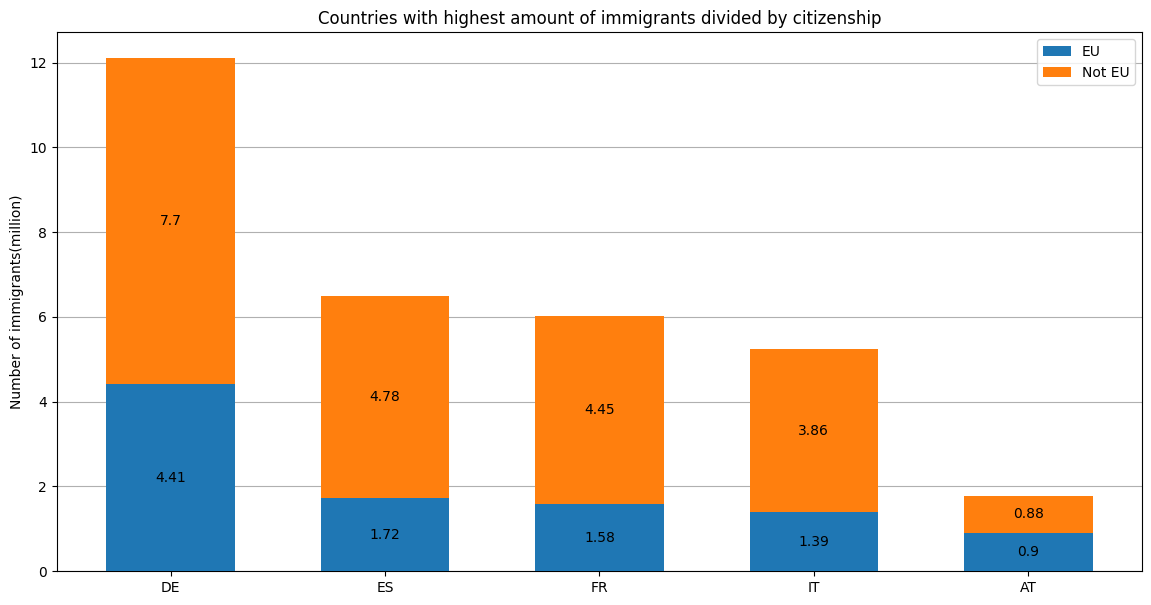

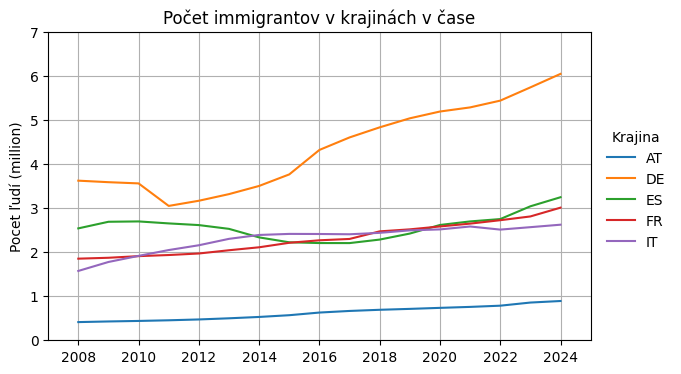

In [ ]:
# URL adries pre dáta
graf_4 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/MigratesFromEUandNot.csv"
graf_5 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/GeneralEU1.csv"

# Graf 4
# Načítanie dát, použijeme iba potrebné stĺpce a prepočet na milióny
df = pd.read_csv(graf_4, usecols=['citizen', 'geo', 'OBS_VALUE']).assign(OBS_VALUE_million=lambda df: df['OBS_VALUE'] / 1000000)

# Filtrovanie celkového počtu cudzincov (FOR_STLS) a premenovanie stĺpca
df_total = df[df['citizen'] == 'FOR_STLS'][['geo', 'OBS_VALUE_million']].rename(columns={'OBS_VALUE_million': 'total'})

# Filtrovanie cudzincov z EÚ (EU27_2020_FOR) a premenovanie stĺpca
df_eu = df[df['citizen'] == 'EU27_2020_FOR'][['geo', 'OBS_VALUE_million']].rename(columns={'OBS_VALUE_million': 'eu'})

# Spojenie dát a výpočet počtu cudzincov mimo EÚ
merged = df_total.merge(df_eu, on='geo').assign(not_eu=lambda x: x['total'] - x['eu'])

# Prevod do širokého formátu, pridanie súčtu a zoradenie podľa celkového počtu
df_wide = (merged.pivot_table(index='geo', values=['eu', 'not_eu'], aggfunc='first')
           .assign(General=lambda x: x['eu'] + x['not_eu'])
           .sort_values('General', ascending=False)
           .reset_index())

# Filtrovanie krajín s najvyšším počtom imigrantov
df_wide = df_wide[df_wide['geo'].isin(countries_highest_number_immigrates)]

# Príprava dát pre graf (EÚ a mimo EÚ)
EU_NOT_counts = {'EU': df_wide['eu'], 'Not EU': df_wide['not_eu']}

# Vytvorenie grafu
fig, ax = plt.subplots(figsize=(14, 7))
bottom = np.zeros(len(df_wide['geo']))

# Vykreslenie stĺpcov pre EÚ a mimo EÚ
for cship, count in EU_NOT_counts.items():
    p = ax.bar(df_wide['geo'], count, 0.6, label=cship, bottom=bottom, zorder=3)
    bottom += count
    ax.bar_label(p, labels=[str(round(val, 2)) for val in count], label_type='center')

# Nastavenie názvu, osí, mriežky a legendy
ax.set_title('Countries with highest amount of immigrants divided by citizenship')
ax.set_ylabel('Number of immigrants(million)')
ax.legend()
ax.grid(axis='y')

# Graf 5
# Načítanie dát, prepočet na milióny
years = list(range(2008, 2025))
df_graf5 = pd.read_csv(graf_5, usecols=['geo', 'TIME_PERIOD', 'OBS_VALUE']).assign(OBS_VALUE_million=lambda df: df['OBS_VALUE'] / 1000000).query('TIME_PERIOD in @years')

# Vytvorenie grafu s líniami
fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(data=df_graf5[df_graf5['geo'].isin(countries_highest_number_immigrates)],
             x='TIME_PERIOD', y='OBS_VALUE_million',
             hue='geo', zorder=3, errorbar=None, ax=ax)

# Nastavenie osí, názvu a rozsahu
ax.set_xlabel('')
ax.set_ylabel('Pocet ľudí (million)')
ax.set(title='Počet immigrantov v krajinách v čase')
ax.legend(bbox_to_anchor=(1.02, 0.7), loc='upper left', borderaxespad=0., title='Krajina', frameon=False)
ax.grid()
ax.set_xlim(2007, 2025)
ax.set_ylim(0, 7)

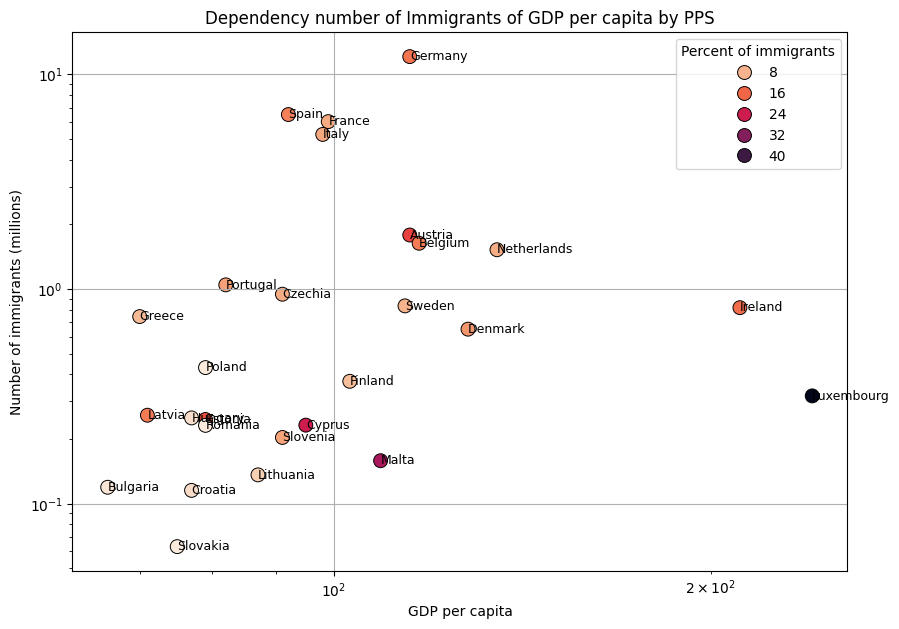

In [ ]:
url_dependency_immigrants_and_GDP = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/GDP_per_capita_in_PPS.csv"
url_for_population = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/population_by_country_of_birth.csv"
df_population_for_sc = pd.read_csv(url_for_population,usecols=['Country/region of birth', 'geo', 'TIME_PERIOD', 'OBS_VALUE']).query(
    'TIME_PERIOD == 2024').query('`Country/region of birth` == "Total"').drop(['Country/region of birth', 'TIME_PERIOD'], axis=1)
df_population_for_sc = df_population_for_sc.rename(columns={'OBS_VALUE': 'Population'})
df_dependency_immigrants_and_GDP = pd.read_csv(url_dependency_immigrants_and_GDP,usecols=['Geopolitical entity (reporting)', 'geo', 'OBS_VALUE'])
df_dependency_immigrants_and_GDP = df_dependency_immigrants_and_GDP.rename(columns={'OBS_VALUE': 'GDP'})
df_dependency_immigrants_and_GDP = pd.merge(df_dependency_immigrants_and_GDP, df_sorted_by_number_immigrates, on='geo').drop(['TIME_PERIOD'], axis=1)
df_dependency_immigrants_and_GDP = pd.merge(df_dependency_immigrants_and_GDP, df_population_for_sc, on='geo')
df_dependency_immigrants_and_GDP['Percent of immigrants'] = df_dependency_immigrants_and_GDP['OBS_VALUE']/df_dependency_immigrants_and_GDP['Population']*100


fig, ax = plt.subplots(figsize=(10, 7))
plot_dependency_immigrants_and_GDP = sns.scatterplot(data=df_dependency_immigrants_and_GDP, x="GDP",
                                                     y="OBS_VALUE_milion", hue="Percent of immigrants",
                                                     s=100, edgecolor="black", linewidth=0.7, palette=sns.color_palette("rocket_r", as_cmap=True), ax=ax)

for i, row in df_dependency_immigrants_and_GDP.iterrows():
    ax.text(
        row["GDP"],
        row["OBS_VALUE_milion"],
        row["Geopolitical entity (reporting)"],
        fontsize=9,
        ha='left',
        va='center'
    )

plt.title("Dependency number of Immigrants of GDP per capita by PPS")
plt.xlabel("GDP per capita")
plt.ylabel("Number of immigrants (millions)")
plt.grid(True)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


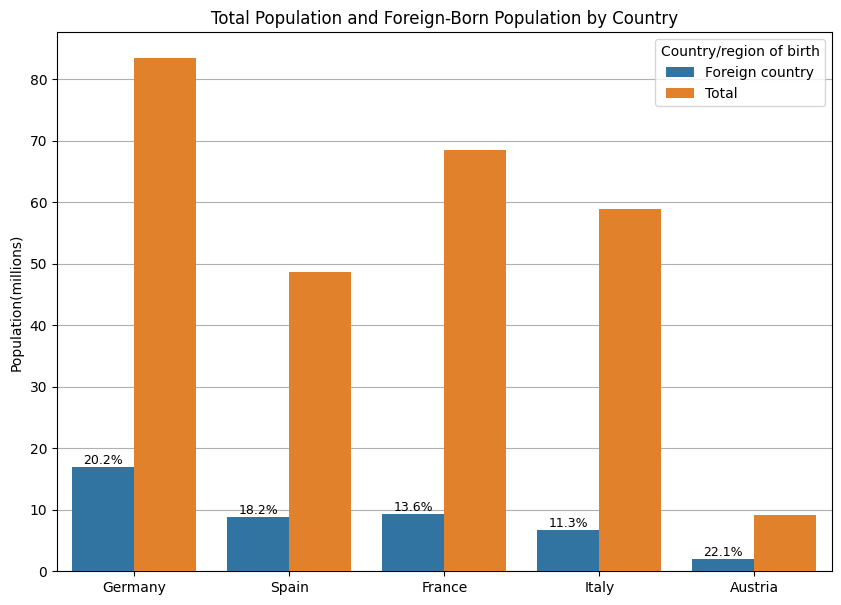

In [ ]:
url_pop_by_country_of_birth = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/population_by_country_of_birth.csv"
df_population_by_country_of_birth = pd.read_csv(url_pop_by_country_of_birth,usecols=['Country/region of birth', 'geo', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE']).query('TIME_PERIOD == 2024')
df_population_by_country_of_birth["OBS_VALUE"] = df_population_by_country_of_birth["OBS_VALUE"]/1000000
df_population_by_country_of_birth_wide = df_population_by_country_of_birth.pivot(index='Geopolitical entity (reporting)',
    columns='Country/region of birth',
    values='OBS_VALUE'
).reset_index()
df_population_by_country_of_birth_wide["Percentage Foreign-Born"] = df_population_by_country_of_birth_wide["Foreign country"]/df_population_by_country_of_birth_wide["Total"]*100
df_population_by_country_of_birth = df_population_by_country_of_birth.merge(
    df_population_by_country_of_birth_wide[['Geopolitical entity (reporting)', 'Percentage Foreign-Born']],
    on='Geopolitical entity (reporting)',
    how='left'
)


fig, ax = plt.subplots(figsize=(10, 7))

df_population_by_country_of_birth_5countries = df_population_by_country_of_birth[df_population_by_country_of_birth['geo'].isin(countries_highest_number_immigrates)]
df_population_by_country_of_birth_5countries = pd.concat([df_population_by_country_of_birth_5countries.query('geo!="AT"'), df_population_by_country_of_birth_5countries.query('geo=="AT"')], ignore_index=True)


plot_for_pop_by_country_of_birth = sns.barplot(data=df_population_by_country_of_birth_5countries, y='OBS_VALUE', x='Geopolitical entity (reporting)', hue='Country/region of birth', ax=ax, zorder=3)

bars = plot_for_pop_by_country_of_birth.patches

df_foreign = df_population_by_country_of_birth_5countries.query('`Country/region of birth` == "Foreign country"').reset_index(drop=True)

foreign_index = 0

for bar in bars:
    if foreign_index < len(df_foreign):
        if abs(bar.get_height() - df_foreign.loc[foreign_index, 'OBS_VALUE']) < 1e-3:
            percent = df_foreign.loc[foreign_index, 'Percentage Foreign-Born']
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{percent:.1f}%",
                ha='center',
                va='bottom',
                fontsize=9,
                color='black'
            )
            foreign_index += 1

ax.set_title('Total Population and Foreign-Born Population by Country')
ax.set_xlabel('')
ax.set_ylabel('Population(millions)')
ax.grid(True, axis='y', zorder=0)

plt.show()

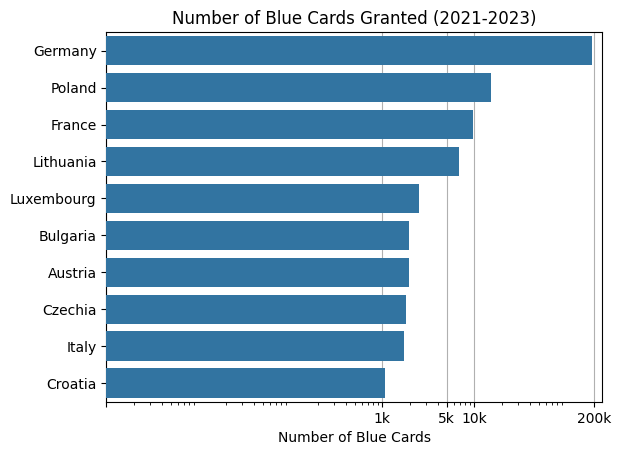

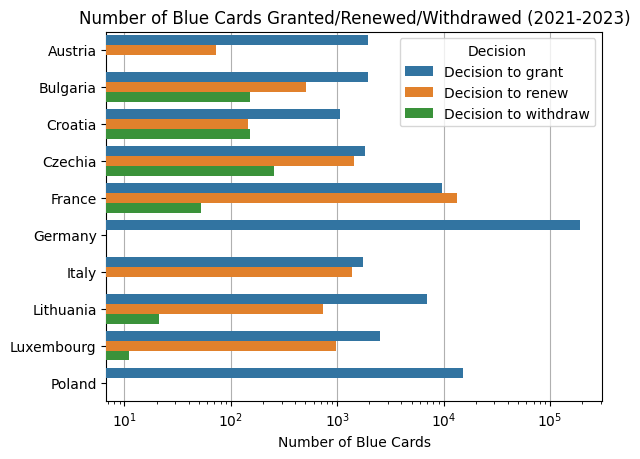

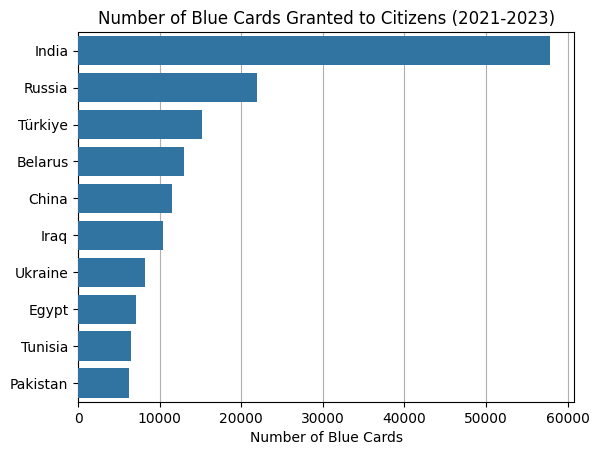

In [ ]:
url_blue_card_without_citizens = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/blue_cards.csv"
url_blue_card_with_citizens = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/BlueCard_by_citizenship.csv"


df_BlueCard_without_citizens = pd.read_csv(url_blue_card_without_citizens,usecols=['geo', 'Geopolitical entity (reporting)',
                                                                                   'isco08', 'International Standard Classification of Occupations 2008 (ISCO-08)', 'TIME_PERIOD', 'OBS_VALUE', 'Decision'])
df_BlueCard_without_citizens_isco8Total_grant = df_BlueCard_without_citizens.query('isco08 == "TOTAL"').query('Decision == "Decision to grant"').groupby(
    by='Geopolitical entity (reporting)')['OBS_VALUE'].sum().reset_index().sort_values('OBS_VALUE', ascending=False)
list_10countries_with_biggest_granting = list(df_BlueCard_without_citizens_isco8Total_grant[:10]['Geopolitical entity (reporting)'])

fig, ax = plt.subplots()
sns.barplot(data=df_BlueCard_without_citizens_isco8Total_grant[:10], y='Geopolitical entity (reporting)', x='OBS_VALUE',ax=ax, zorder=3)
ax.set_ylabel('')
ax.set_xlabel('Number of Blue Cards')
ax.set_title('Number of Blue Cards Granted (2021-2023)')
ax.set_xscale('log')
ax.grid(True, axis='x', zorder=0)
plt.xticks([1, 1000, 5000, 10000, 200000], ['', '1k', '5k', '10k', '200k'])


df_BlueCard_without_citizens_dividedByICSO08 = df_BlueCard_without_citizens.query('isco08 == "TOTAL"').groupby(by=['Decision', 'Geopolitical entity (reporting)', 'geo'])['OBS_VALUE'].sum().reset_index()


fig, ax = plt.subplots()
sns.barplot(data=df_BlueCard_without_citizens_dividedByICSO08[df_BlueCard_without_citizens_dividedByICSO08['Geopolitical entity (reporting)'].isin(list_10countries_with_biggest_granting)],
            y='Geopolitical entity (reporting)', x='OBS_VALUE', hue='Decision',ax=ax, zorder=3)
ax.set_ylabel('')
ax.set_xlabel('Number of Blue Cards')
ax.set_title('Number of Blue Cards Granted/Renewed/Withdrawed (2021-2023)')
ax.set_xscale('log')
ax.grid(True, axis='x', zorder=0)


df_BlueCard_with_citizens = pd.read_csv(url_blue_card_with_citizens,usecols=['citizen', 'Country of citizenship', 'TIME_PERIOD', 'OBS_VALUE']).groupby(by=['citizen', 'Country of citizenship'])['OBS_VALUE'].sum().reset_index().sort_values('OBS_VALUE', ascending=False)

fig, ax = plt.subplots()
sns.barplot(data=df_BlueCard_with_citizens[:10], y='Country of citizenship', x='OBS_VALUE',ax=ax, zorder=3)
ax.set_ylabel('')
ax.set_xlabel('Number of Blue Cards')
ax.set_title('Number of Blue Cards Granted to Citizens (2021-2023)')
ax.grid(True, axis='x', zorder=0)

,citizen,Country of citizenship,TIME_PERIOD,OBS_VALUE_milion
564,UA,Ukraine,2021,0.096015
565,UA,Ukraine,2022,1.708156
566,UA,Ukraine,2023,0.554615


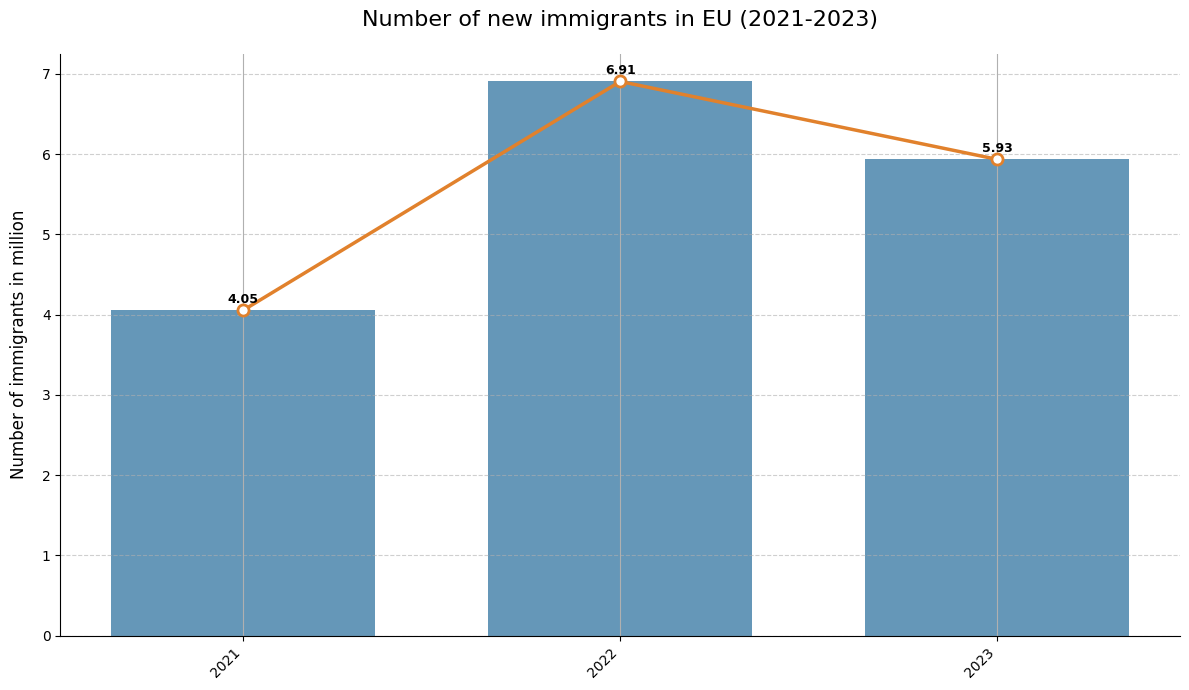

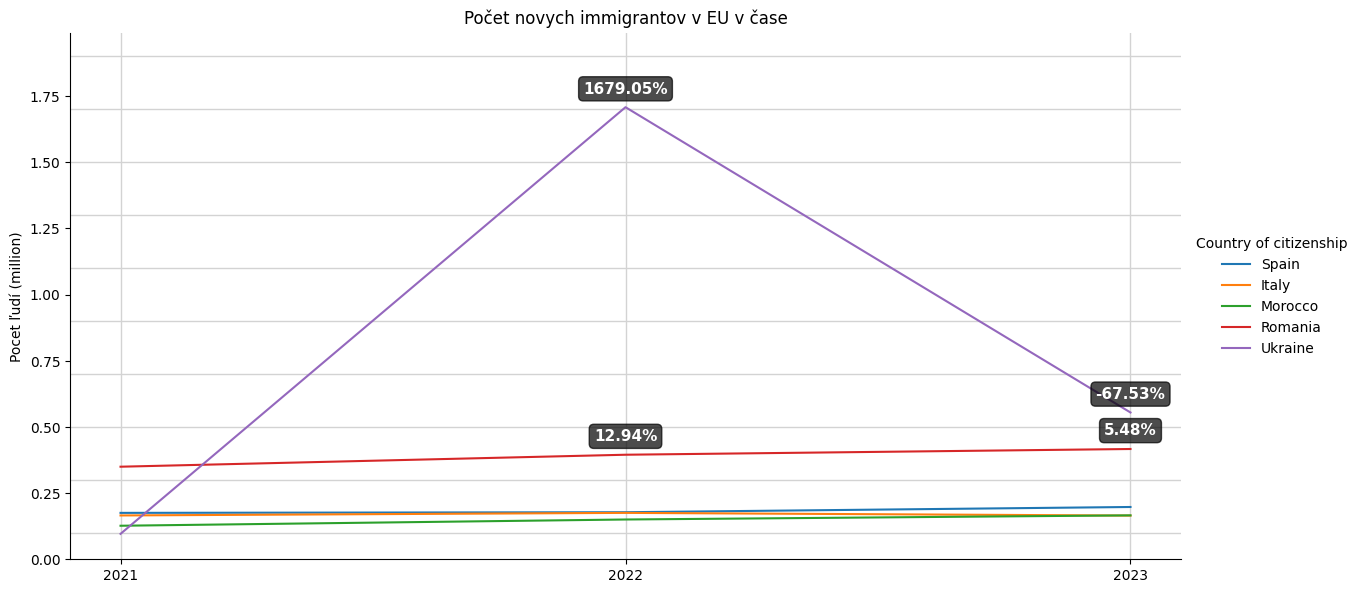

In [ ]:
url_new_immigrants = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/new_immigrants.csv"
df_new_immigrants = pd.read_csv(url_new_immigrants,usecols=['citizen', 'Country of citizenship', 'geo', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE'])
df_new_immigrants['OBS_VALUE_milion'] = df_new_immigrants['OBS_VALUE']/1000000
df_new_immigrants_inWholeEU = df_new_immigrants[df_new_immigrants['geo']=='EU27_2020']
df_new_immigrants_by_citizenship = df_new_immigrants[df_new_immigrants['geo']!='EU27_2020'].groupby(by=['citizen', 'Country of citizenship', 'TIME_PERIOD'])['OBS_VALUE_milion'].sum().reset_index()
display(df_new_immigrants_by_citizenship.query('citizen==\"UA\"'))

fig, ax = plt.subplots(figsize=(12, 7))
bar_color = '#3274A1'
line_color = '#E1812C'
bars = ax.bar(df_new_immigrants_inWholeEU['TIME_PERIOD'], df_new_immigrants_inWholeEU['OBS_VALUE_milion'], color=bar_color, alpha=0.75, width=0.7)
line = ax.plot(df_new_immigrants_inWholeEU['TIME_PERIOD'], df_new_immigrants_inWholeEU['OBS_VALUE_milion'], color=line_color, lw=2.5,
    marker='o', markersize=8, markerfacecolor='white', markeredgecolor=line_color, markeredgewidth=2)

years = df_new_immigrants_inWholeEU['TIME_PERIOD'].unique()
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45, ha='right')
ax.bar_label(bars, fmt='%.2f', fontsize=9, fontweight='bold', padding=3)
ax.set_xlabel('')
ax.set_ylabel('Number of immigrants in million', fontsize=12, labelpad=10)
ax.set_title('Number of new immigrants in EU (2021-2023)', fontsize=16, pad=20)
ax.grid(axis='x')
plt.grid(axis='y', alpha=0.6, linestyle='--')
sns.despine(left=False, bottom=False)
plt.tight_layout()

list_immigrants_themost = list(df_new_immigrants_by_citizenship.groupby(by='Country of citizenship')['OBS_VALUE_milion'].sum().reset_index().sort_values('OBS_VALUE_milion', ascending=False)['Country of citizenship'][1:6])
df_new_immigrants_by_citizenship = df_new_immigrants_by_citizenship[df_new_immigrants_by_citizenship['Country of citizenship'].isin(list_immigrants_themost)]

plot_for_number_newimmigrates_trough_time = sns.relplot(data=df_new_immigrants_by_citizenship,
                                                     x='TIME_PERIOD', y='OBS_VALUE_milion',
                                                     hue='Country of citizenship', kind="line", zorder=3, height=6, aspect=2)
plot_for_number_newimmigrates_trough_time.set_axis_labels('', 'Pocet ľudí (million)')
plot_for_number_newimmigrates_trough_time.set(title='Počet novych immigrantov v EU v čase')
ax = plot_for_number_newimmigrates_trough_time.axes[0][0]
for i in range(1, 20, 2):
  ax.axhline(y=i/10, color='lightgray', linewidth=1, zorder=0)
for i in range(2021, 2024, 1):
  ax.axvline(x=i, color='lightgray', linewidth=1, zorder=0)
ax.set_xticks(range(2021, 2024, 1))

df_new_immigrants_by_citizenship['percentage_change'] = df_new_immigrants_by_citizenship.groupby('Country of citizenship')['OBS_VALUE_milion'].pct_change() * 100

# Annotate the percentage change
for country in ['Ukraine', 'Romania']:  # df_new_immigrants_by_citizenship['Country of citizenship'].unique()
    country_data = df_new_immigrants_by_citizenship[df_new_immigrants_by_citizenship['Country of citizenship'] == country]
    for i, row in country_data.iterrows():
        x_pos = row['TIME_PERIOD']
        y_pos = row['OBS_VALUE_milion']
        perc_change = row['percentage_change']
        if pd.notna(perc_change):
            ax.annotate(f'{perc_change:.2f}%',
                        (x_pos, y_pos),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center',
                        fontsize=11,
                        color='white',
                        weight='bold',
                        bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.3'))

# Настройка, чтоб отсчет в графике был от нуля\n",
plt.ylim(0, )

plt.show()

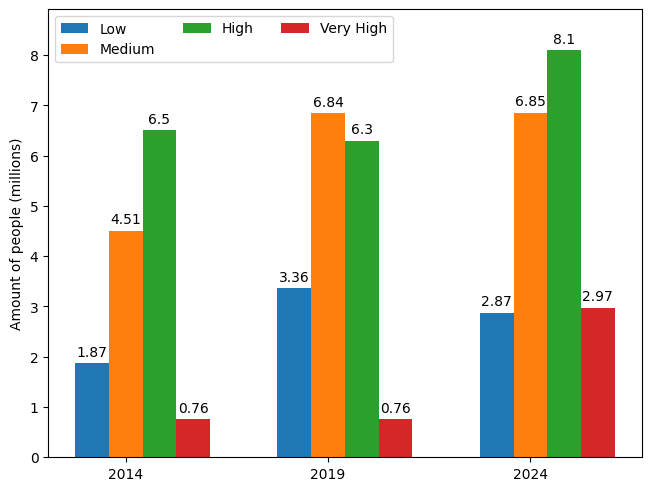

In [ ]:
# Human_D_of_citizicitizenship
url_H = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/human.csv"
data_HD = pd.read_csv(url_H,usecols=['citizen', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE'])
data_HD['OBS_VALUE'] = data_HD['OBS_VALUE'] / 1000000
data_HD['OBS_VALUE'] = data_HD['OBS_VALUE'].round(2)
grouped = data_HD.groupby(['citizen', 'TIME_PERIOD'])['OBS_VALUE'].sum().unstack(fill_value=0)
grouped = grouped.transpose()
grouped.columns = ['High','Low','Medium',"Very High"]
grouped = grouped[['Low', 'Medium', 'High', 'Very High']]
years = grouped.index.tolist()
categories = grouped.columns.tolist()
values = grouped.values

x = np.arange(len(years))  * 1.5
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for category  in categories:
    offset = width * multiplier
    rects = ax.bar(x + offset, grouped[category], width, label=category)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Amount of people (millions)')
ax.set_title('')
ax.set_xticks(x + width, years)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, grouped.values.max() * 1.1)

plt.show()

(0.0, 1.837)

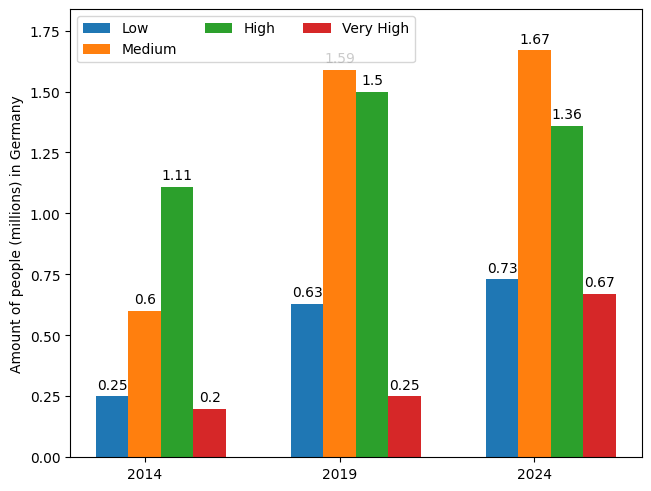

In [ ]:
data_HD_G =data_HD[data_HD['Geopolitical entity (reporting)']=='Germany']
groupedG = data_HD_G.groupby(['citizen', 'TIME_PERIOD'])['OBS_VALUE'].sum().unstack(fill_value=0)
groupedG = groupedG.transpose()
groupedG.columns = ['High','Low','Medium',"Very High"]
groupedG = groupedG[['Low', 'Medium', 'High', 'Very High']]
years = groupedG.index.tolist()
categories = groupedG.columns.tolist()
values = groupedG.values

x = np.arange(len(years))  * 1.5
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for category  in categories:
    offset = width * multiplier
    rects = ax.bar(x + offset, groupedG[category], width, label=category)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Amount of people (millions) in Germany')
ax.set_title('')
ax.set_xticks(x + width, years)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, groupedG.values.max() * 1.1)


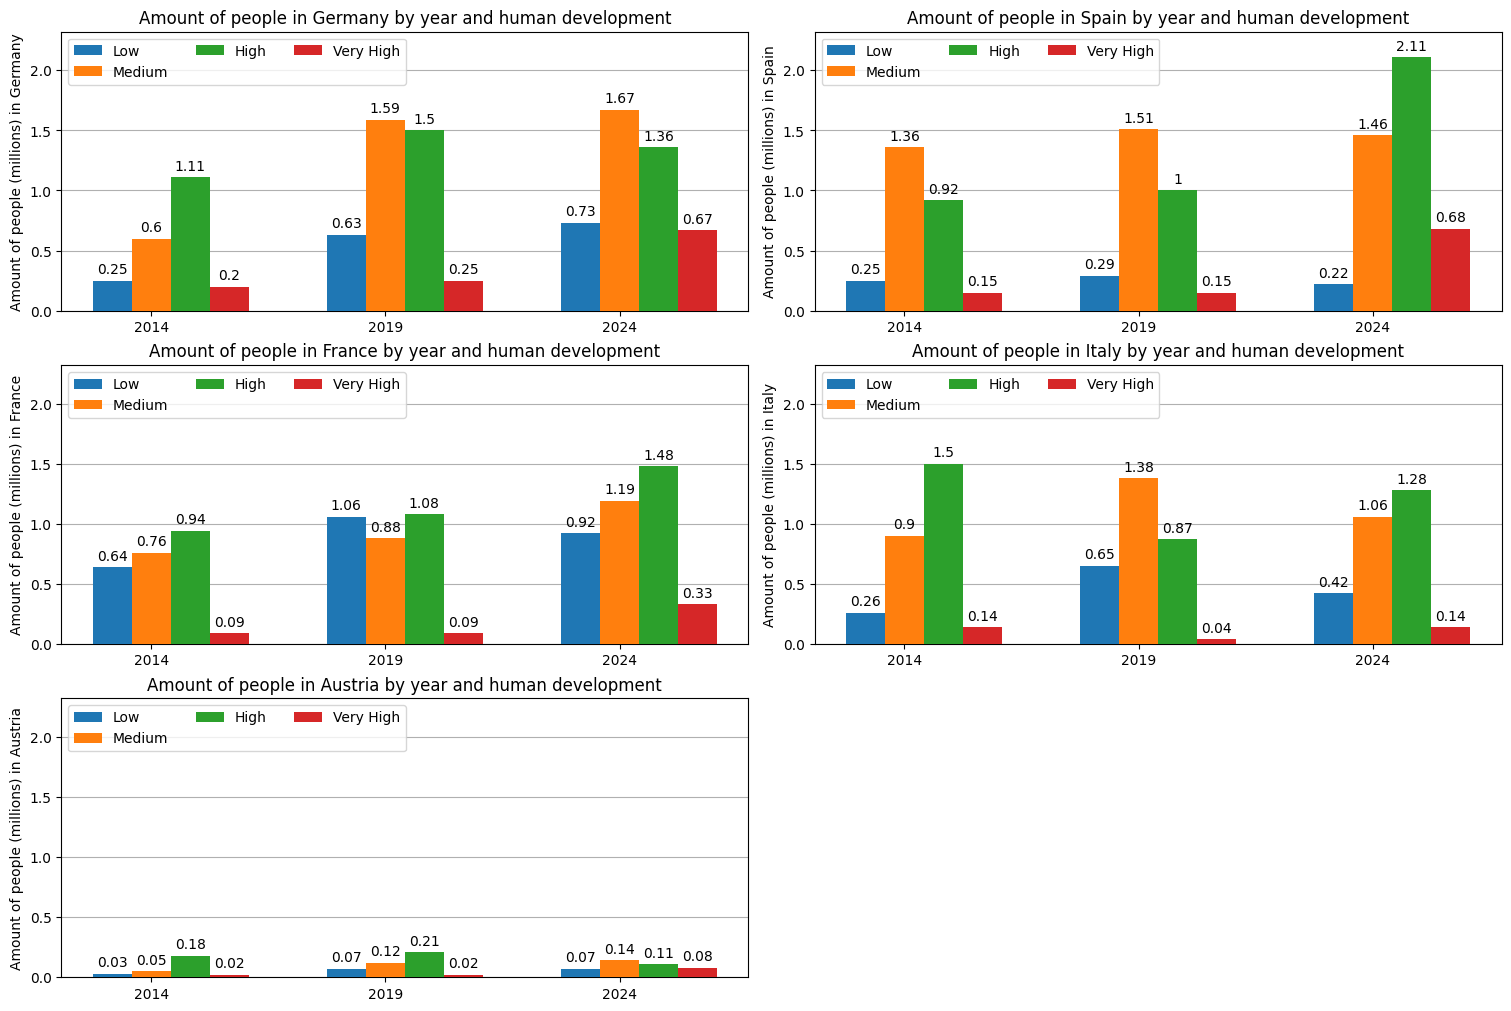

In [ ]:
def plot_country(ax, data, country_name, max_y):
    data_country = data[data['Geopolitical entity (reporting)'] == country_name]
    grouped = data_country.groupby(['citizen', 'TIME_PERIOD'])['OBS_VALUE'].sum().unstack(fill_value=0).transpose()
    grouped.columns = ['High', 'Low', 'Medium', 'Very High']
    grouped = grouped[['Low', 'Medium', 'High', 'Very High']]

    years = grouped.index.tolist()
    categories = grouped.columns.tolist()
    x = np.arange(len(years)) * 1.5
    width = 0.25
    multiplier = 0
    #fig, ax = plt.subplots(layout='constrained')
    for category in categories:
        offset = width * multiplier
        rects = ax.bar(x + offset, grouped[category], width, label=category, zorder=3)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_ylabel(f'Amount of people (millions) in {country_name}')
    ax.set_title(f'Amount of people in {country_name} by year and human development')
    ax.set_xticks(x + width, years)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, max_y*1.1)
    ax.grid(True, axis='y', zorder=0)
    #ax.set_ylim(0, grouped.values.max() * 1.1)
    #plt.show()

countries = ['Germany', 'Spain', 'France', 'Italy', 'Austria']

max_y = 0
for country in countries:
    data_country = data_HD[data_HD['Geopolitical entity (reporting)'] == country]
    grouped = data_country.groupby(['citizen', 'TIME_PERIOD'])['OBS_VALUE'].sum().unstack(fill_value=0).transpose()
    total = grouped.max(axis=1).max()
    if total > max_y:
        max_y = total

fig, ax = plt.subplots(3, 2, figsize=(15, 10), layout='constrained')
axes = ax.flatten()
for i, country in enumerate(countries):
    plot_country(axes[i], data_HD, country, max_y)
for j in range(len(countries), len(axes)):
    fig.delaxes(axes[j])
plt.show()

<ipython-input-45-09e9b18acdaa>:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar1.set_ticklabels([0, 2, 4, 6, 8, 10, 12])
<ipython-input-45-09e9b18acdaa>:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar2.set_ticklabels([0, 10, 20, 30, 40])


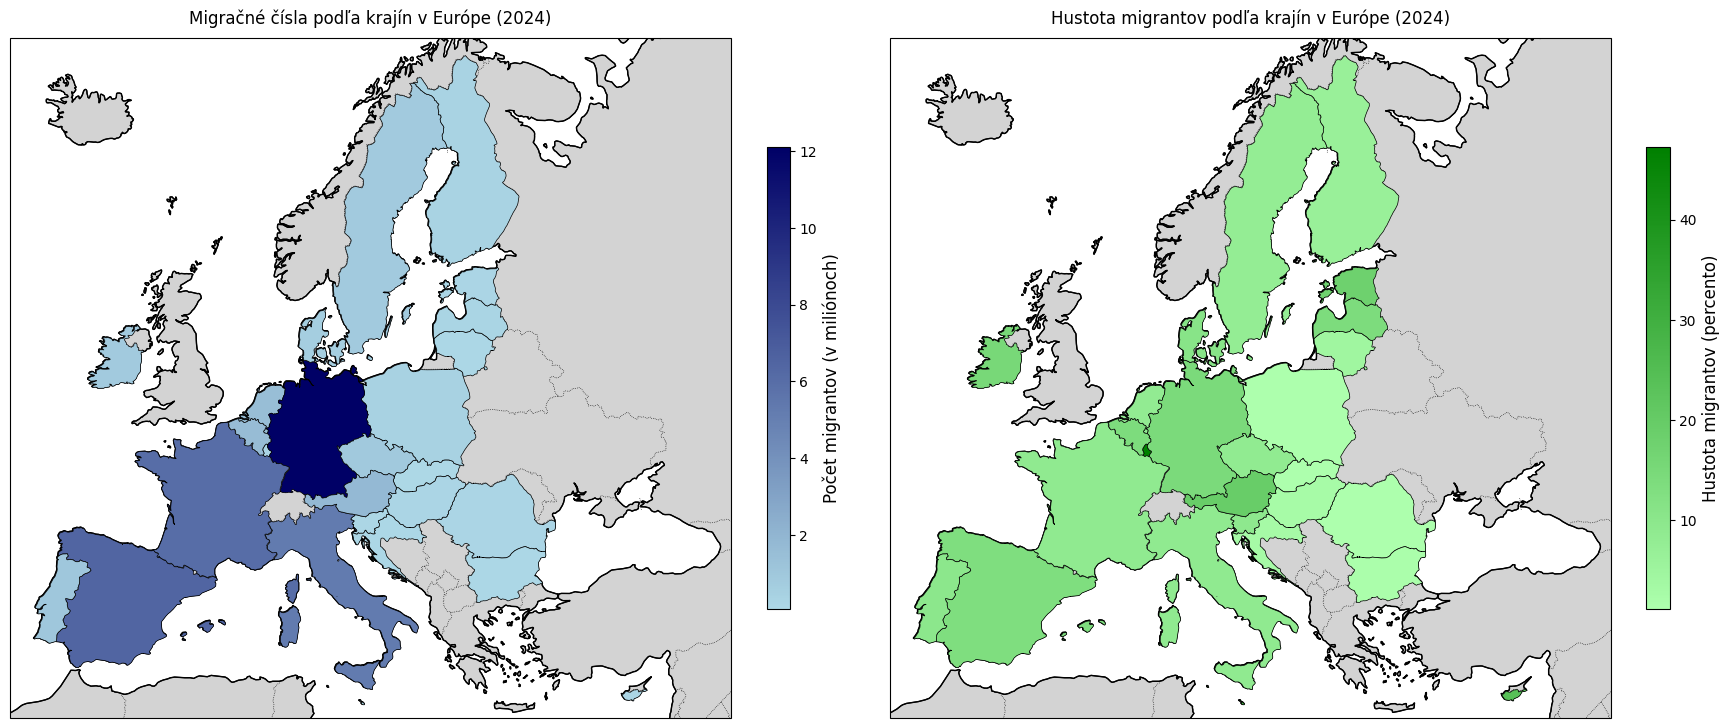

In [45]:
# Načítanie dátových súborov z GitHubu
url1 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/points_of_country.csv"
url2 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/MigrantsAndCitizens.csv"

# Načítanie dát o krajinách (názvy, kódy, súradnice)
data_frame_by_points_of_country = pd.read_csv(url1, usecols=['Country', 'ISO-ALPHA-2', 'Latitude', 'Longitude'])

# Spracovanie dát o migrácii - transformácia do širšej tabuľky a výpočet hustoty migrantov
df_density_migrants = (pd.read_csv(url2, usecols=['geo', 'citizen', 'OBS_VALUE'])
                      .pivot(index='geo', columns='citizen', values='OBS_VALUE')
                      .reset_index()
                      .assign(density = lambda df: df['FOR_STLS'] / df['TOTAL'])
                      .drop(['FOR_STLS', 'TOTAL'], axis=1))

# Vytvorenie pomocného dátového rámca s kódmi krajín
data = {
    "geo": list(df['geo'].unique())
}

# Spojenie dát o polohách krajín s ich kódmi
points = (pd.merge(pd.DataFrame(data), data_frame_by_points_of_country, left_on='geo', right_on='ISO-ALPHA-2'))

# Spojenie všetkých potrebných dát do jedného rámca
nove_frame = pd.merge(points, df_sorted_by_number_immigrates, on="geo")
nove_frame = pd.merge(nove_frame, df_density_migrants, on="geo")

# Vytvorenie obrázka s dvoma podgrafmi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8),
                              subplot_kw={'projection': ccrs.LambertConformal(15.0, 50.0)})

# Spoločné nastavenia pre oba grafy
for ax in (ax1, ax2):
    ax.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())  # Rozsah zobrazenia (Európa)
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')  # Pozadie pevniny
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)  # Pobrežné línie
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)  # Hranice krajín

# Vytvorenie farebnej mapy pre migračné údaje (od svetlej po tmavú modrú)
cmap = LinearSegmentedColormap.from_list("light_blue_to_dark_blue", [
    (0.678, 0.847, 0.902),  # svetlá modrá
    (0.0, 0.0, 0.4)         # tmavá modrá
])

# Vytvorenie farebnej mapy pre hustotu migrantov (od svetlej po tmavú zelenú)
cmap2 = LinearSegmentedColormap.from_list("light_green_to_dark_green", [
    (0.678, 1.0, 0.678),  # svetlá zelená
    (0.0, 0.5, 0.0)       # tmavá zelená
])

# Normalizácia hodnôt pre farebné mapovanie
norm_obs = plt.Normalize(nove_frame['OBS_VALUE'].min(), nove_frame['OBS_VALUE'].max())
norm_density = plt.Normalize(nove_frame['density'].min(), nove_frame['density'].max())

# Vytvorenie slovníkov pre rýchle vyhľadávanie hodnôt podľa názvu krajiny
migration_dict = dict(zip(nove_frame['Country'], nove_frame['OBS_VALUE']))
migration_dict2 = dict(zip(nove_frame['Country'], nove_frame['density']))

# Vykreslenie prvého grafu (migračné čísla)
for country in shapereader.Reader(shapereader.natural_earth('50m', 'cultural', 'admin_0_countries')).records():
    if country.attributes['NAME_LONG'] in migration_dict:
        ax1.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor=cmap(norm_obs(migration_dict[country.attributes['NAME_LONG']])),
                          edgecolor='black', linewidth=0.5)

# Vykreslenie druhého grafu (hustota migrantov)
for country in shapereader.Reader(shapereader.natural_earth('50m', 'cultural', 'admin_0_countries')).records():
    if country.attributes['NAME_LONG'] in migration_dict2:
        ax2.add_geometries([country.geometry], ccrs.PlateCarree(),
                           facecolor=cmap2(norm_density(migration_dict2[country.attributes['NAME_LONG']])),
                           edgecolor='black', linewidth=0.5)

# Pridanie farebnej legendy pre prvý graf
cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm_obs), ax=ax1, shrink=0.6, pad=0.04)
cbar1.set_label('Počet migrantov (v miliónoch)', fontsize=12)
cbar1.set_ticklabels([0, 2, 4, 6, 8, 10, 12])
ax1.set_title('Migračné čísla podľa krajín v Európe (2024)', fontsize=12, pad=10)

# Pridanie farebnej legendy pre druhý graf
cbar2 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap2, norm=norm_density), ax=ax2, shrink=0.6, pad=0.04)
cbar2.set_label('Hustota migrantov (percento)', fontsize=12)
cbar2.set_ticklabels([0, 10, 20, 30, 40])
ax2.set_title('Hustota migrantov podľa krajín v Európe (2024)', fontsize=12, pad=10)

# Úprava rozloženia grafov
plt.tight_layout()

pass

UndefinedVariableError: name 'TIME_PERIOD' is not defined

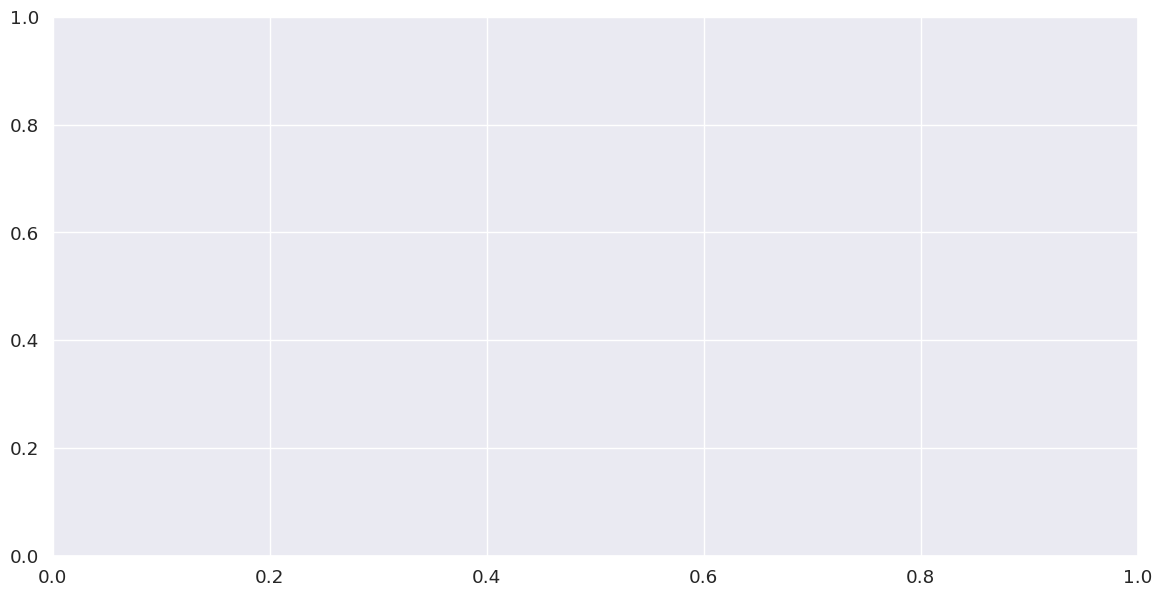

In [ ]:
df['OBS_VALUE_milion'] = df['OBS_VALUE'] /1000000
osnova = df[df['geo'].isin(countries_highest_number_immigrates)]
osnova = pd.concat([osnova.query('geo!="AT"'), osnova.query('geo=="AT"')], ignore_index=True)

sns.set_theme(font_scale=1.2)
fig, axes = plt.subplots(figsize=(14, 7))

barplot = sns.barplot(data=osnova.query("TIME_PERIOD == 2024"),
            x='geo', y='OBS_VALUE_milion', hue='sex', ax=axes)
axes.set_ylabel('Pocet ľudí (million)')
axes.set_xlabel(None)
axes.set_title('Females and Males in 2024')
for container in barplot.containers:
    axes.bar_label(container, fmt='%.2f')
axes.legend(title='Pohlavie')

grid = sns.relplot(data=osnova, x='TIME_PERIOD', y='OBS_VALUE_milion',
                   col='geo', col_wrap=5, kind="line", height=3,
                   aspect=1,hue='sex')

grid.set_axis_labels('', 'Pocet ľudí (million)')
grid.set_titles('') #"{col_name}"
# Зафігачив, аби обидва плоти були одного розміру
grid.figure.set_size_inches(12.18, 4)
grid.figure.subplots_adjust(wspace=0.05,)
grid._legend.remove()

#Редагував для читабельності, оптимізував +стилізація
# -Н


plt.show()
pass

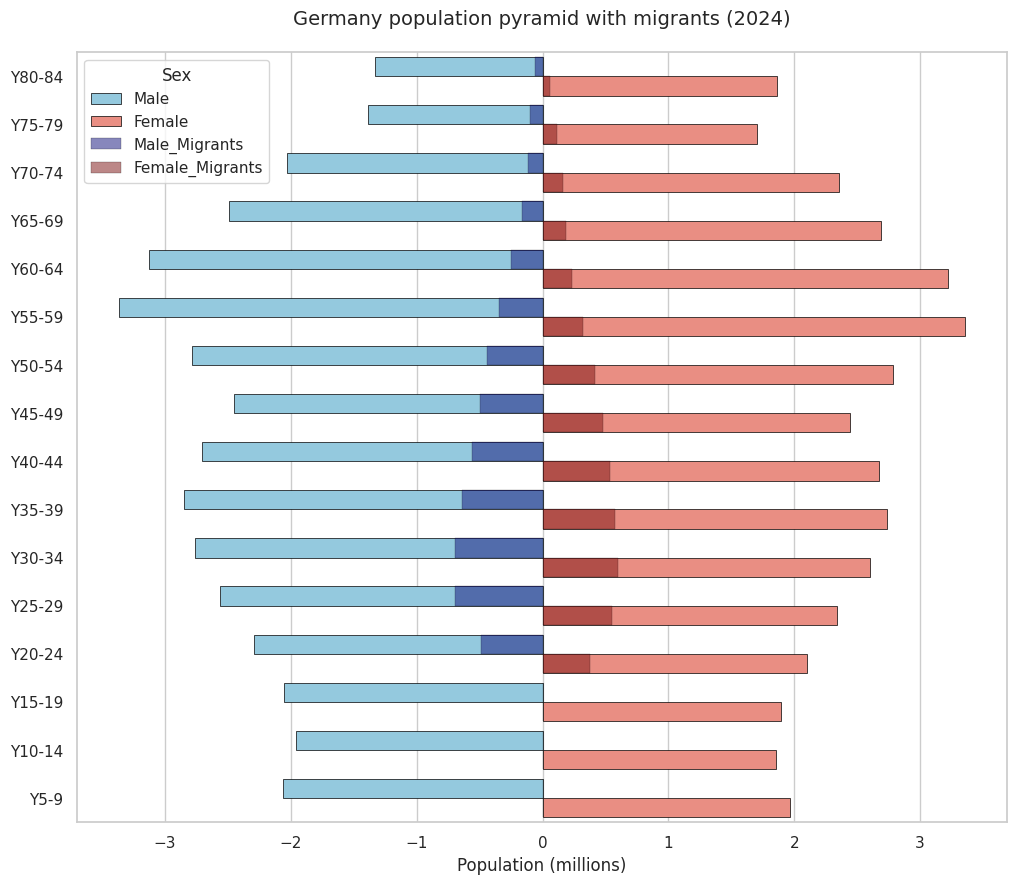

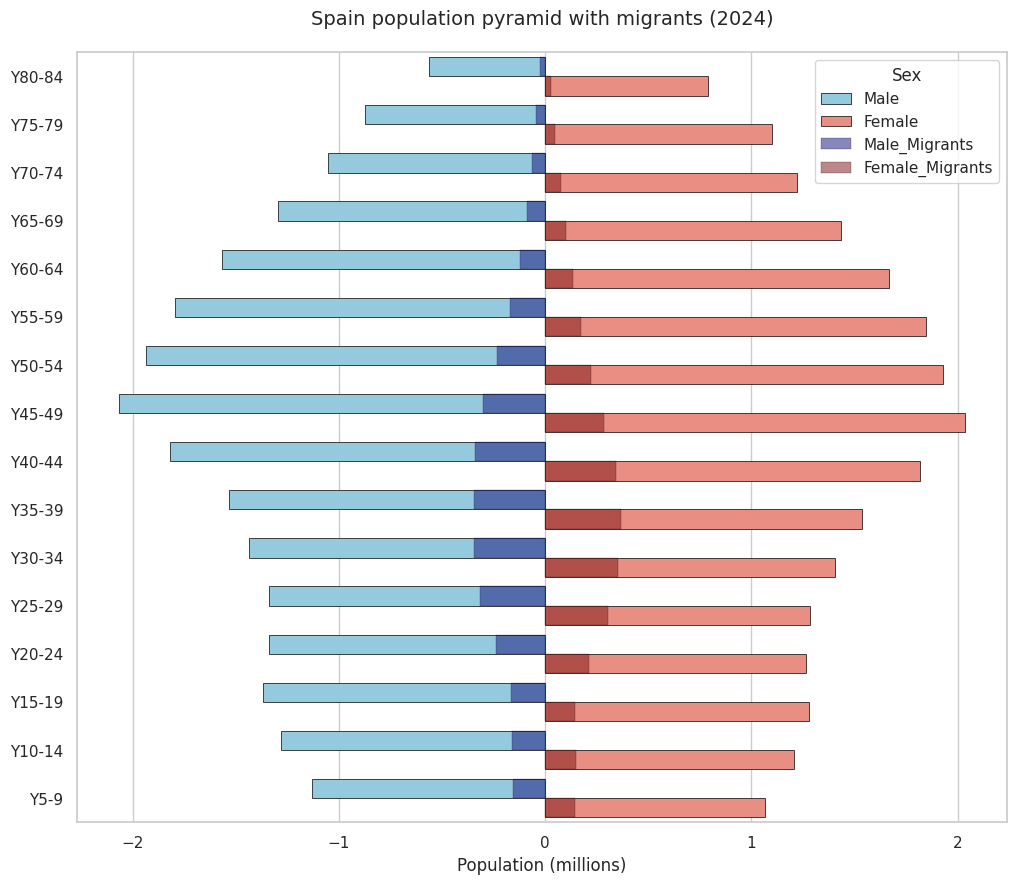

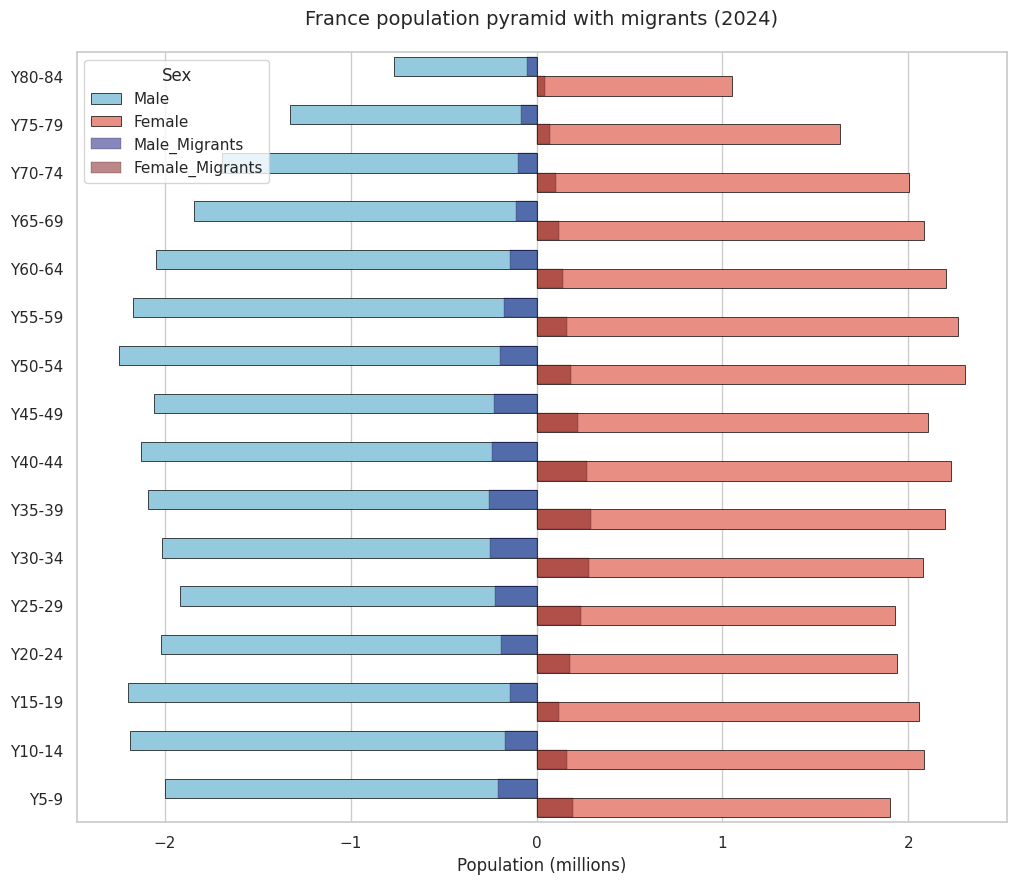

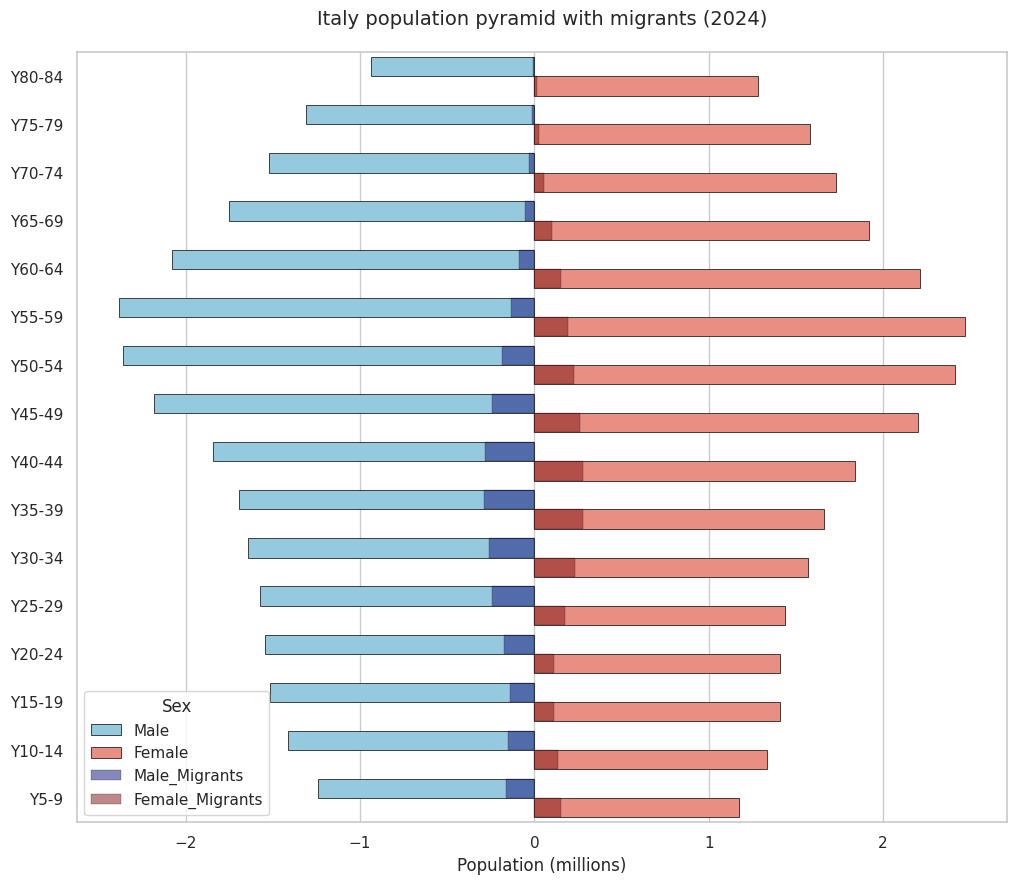

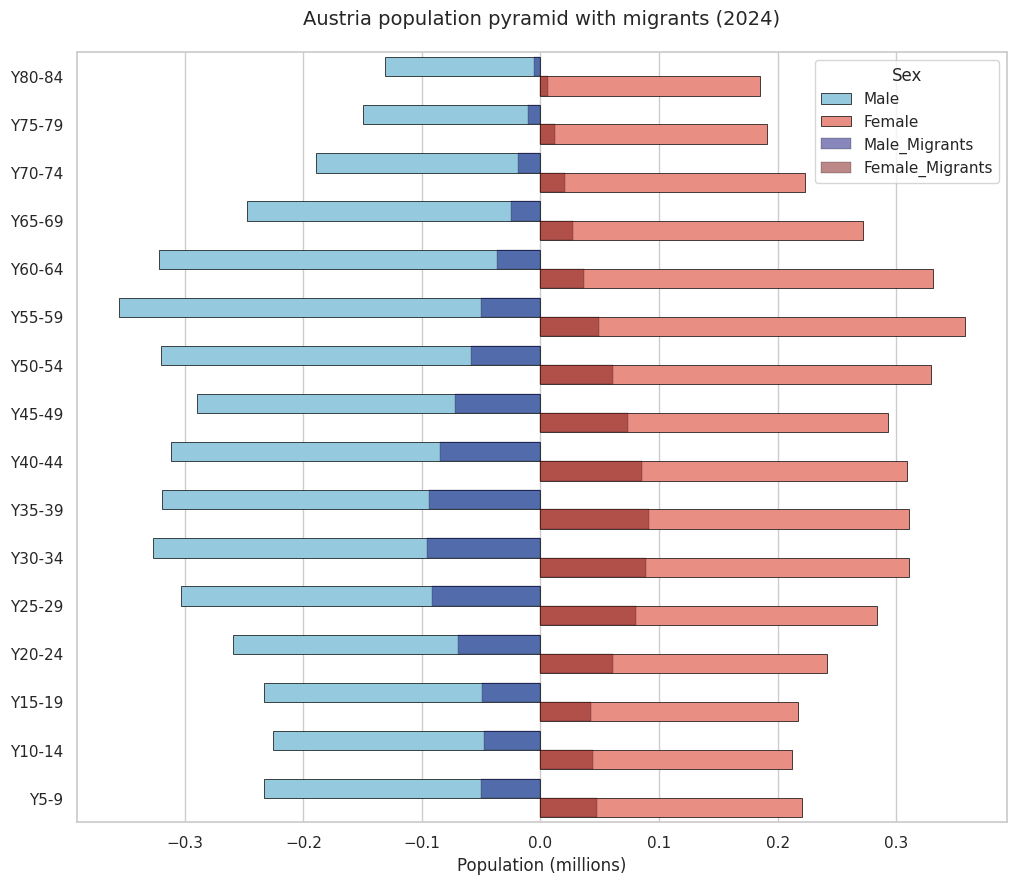

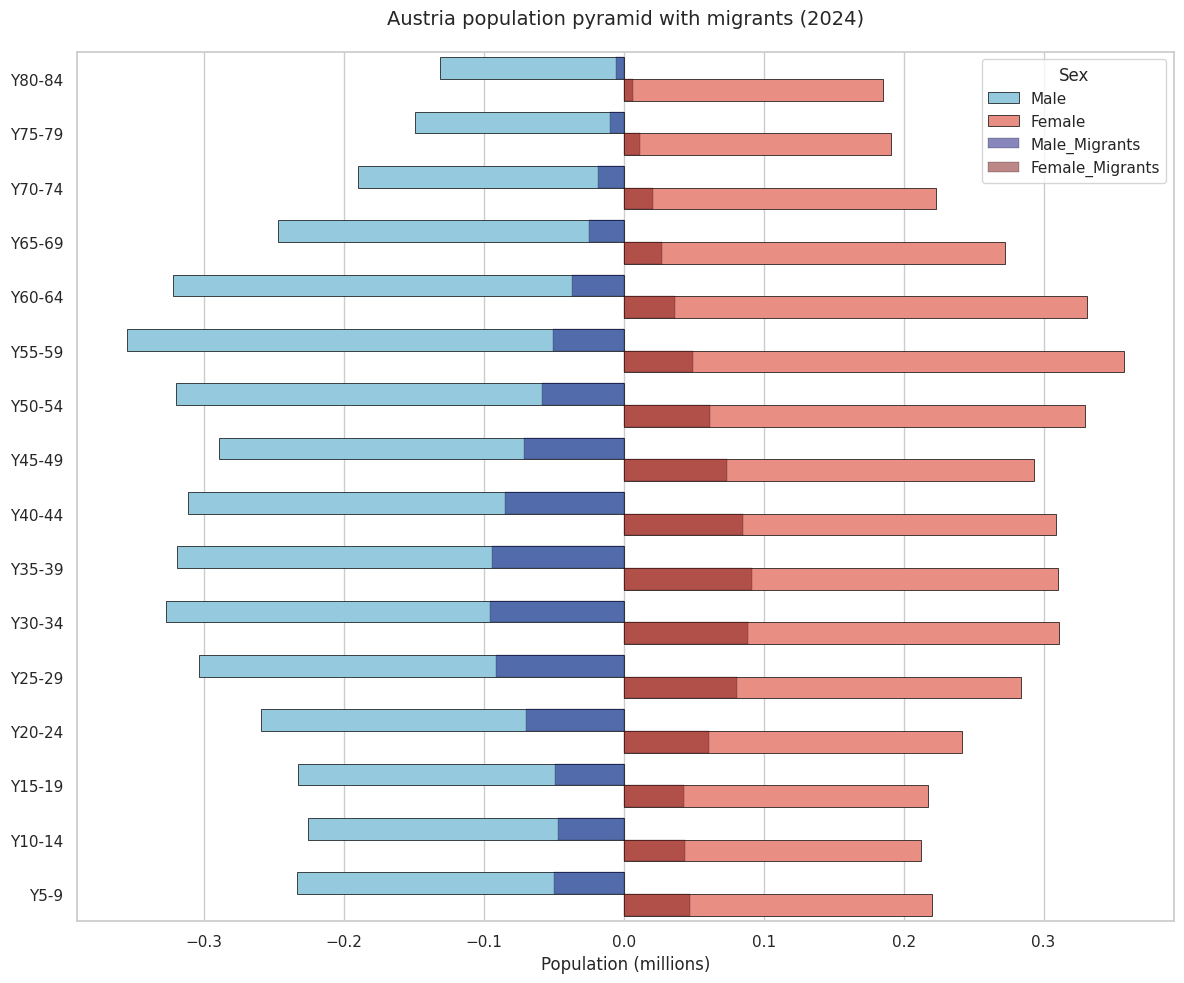

In [ ]:
urlDemo = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/ForDemoPiramid.csv"

df_for_demo_piramids = pd.read_csv(urlDemo).drop(['STRUCTURE','STRUCTURE_ID', 'CONF_STATUS', 'OBS_FLAG', 'freq', 'TIME_PERIOD', 'unit'], axis=1)

def draw_piramid(name, short_name, df_for_demo_piramids):
  age_order=['Y80-84',
  'Y75-79',
  'Y70-74',
  'Y65-69',
  'Y60-64',
  'Y55-59',
  'Y50-54',
  'Y45-49',
  'Y40-44',
  'Y35-39',
  'Y30-34',
  'Y25-29',
  'Y20-24',
  'Y15-19',
  'Y10-14',
  'Y5-9']
  df_for_demo_piramids_M_total = df_for_demo_piramids.query('sex=="M"').query('geo==@short_name').query('citizen=="TOTAL"')
  df_for_demo_piramids_M_total['OBS_VALUE_milion'] = -df_for_demo_piramids_M_total['OBS_VALUE']/1000000
  df_for_demo_piramids_M_total = df_for_demo_piramids_M_total.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Male'}).rename(columns={'age': 'Age'})

  df_for_demo_piramids_F_total = df_for_demo_piramids.query('sex=="F"').query('geo==@short_name').query('citizen=="TOTAL"')
  df_for_demo_piramids_F_total['OBS_VALUE_milion'] = df_for_demo_piramids_F_total['OBS_VALUE']/1000000
  df_for_demo_piramids_F_total = df_for_demo_piramids_F_total.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Female'}).rename(columns={'age': 'Age'})


  df_for_demo_piramids_M_migr = df_for_demo_piramids.query('sex=="M"').query('geo==@short_name').query('citizen=="FOR_STLS"')
  df_for_demo_piramids_M_migr['OBS_VALUE_milion'] = -df_for_demo_piramids_M_migr['OBS_VALUE']/1000000
  df_for_demo_piramids_M_migr = df_for_demo_piramids_M_migr.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Male_Migrants'}).rename(columns={'age': 'Age'})
  if short_name == 'DE':
    missing_ages = ["Y5-9", "Y10-14", "Y15-19"]
    df_missing = pd.DataFrame({
        'Age': missing_ages,
        'Male_Migrants': 0.0
    })
    df_for_demo_piramids_M_migr = pd.concat([
        df_for_demo_piramids_M_migr,
        df_missing
    ], ignore_index=True)

  df_for_demo_piramids_F_migr = df_for_demo_piramids.query('sex=="F"').query('geo==@short_name').query('citizen=="FOR_STLS"')
  df_for_demo_piramids_F_migr['OBS_VALUE_milion'] = df_for_demo_piramids_F_migr['OBS_VALUE']/1000000
  df_for_demo_piramids_F_migr = df_for_demo_piramids_F_migr.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Female_Migrants'}).rename(columns={'age': 'Age'})
  if short_name == 'DE':
    missing_ages = ["Y5-9", "Y10-14", "Y15-19"]
    df_missing = pd.DataFrame({
        'Age': missing_ages,
        'Female_Migrants': 0.0
    })
    df_for_demo_piramids_F_migr = pd.concat([
        df_for_demo_piramids_F_migr,
        df_missing
    ], ignore_index=True)

  df_for_demo_piramids_total = pd.merge(df_for_demo_piramids_M_total, df_for_demo_piramids_F_total, on='Age')
  df_for_demo_piramids_migr = pd.merge(df_for_demo_piramids_M_migr, df_for_demo_piramids_F_migr, on='Age')
  df_for_demo_piramids = pd.merge(df_for_demo_piramids_total, df_for_demo_piramids_migr, on='Age')

  sns.set_theme(style="whitegrid")
  plt.figure(figsize=(12, 10))

  sns.barplot(
      data=df_for_demo_piramids.melt(id_vars="Age", value_vars=["Male", "Female"], var_name="Sex", value_name="Population"),
      y="Age",
      x="Population",
      hue="Sex",
      order=age_order,
      palette={"Male": "skyblue", "Female": "salmon"},
      edgecolor="black",
      linewidth=0.5,
  )

  sns.barplot(
      data=df_for_demo_piramids.melt(id_vars="Age", value_vars=["Male_Migrants", "Female_Migrants"], var_name="Sex", value_name="Migrants"),
      y="Age",
      x="Migrants",
      hue="Sex",
      order=age_order,
      palette={"Male_Migrants": "darkblue", "Female_Migrants": "darkred"},
      alpha=0.5,
      edgecolor="black",
      linewidth=0.3,
  )

  plt.title(name + " population pyramid with migrants (2024)", fontsize=14, pad=20)
  plt.xlabel("Population (millions)")
  plt.ylabel("")



#GERMANY
draw_piramid('Germany', 'DE', df_for_demo_piramids)
#GERMANY

#SPAIN
draw_piramid('Spain', 'ES', df_for_demo_piramids)
#SPAIN

#FRANCE
draw_piramid('France', 'FR', df_for_demo_piramids)
#FRANCE

#ITALY
draw_piramid('Italy', 'IT', df_for_demo_piramids)
#ITALY

#AUSTRIA
draw_piramid('Austria', 'AT', df_for_demo_piramids)
#AUSTRIA
draw_piramid('Austria', 'AT', df_for_demo_piramids)
plt.tight_layout()
plt.show()

citizen,EU,Not EU
age,,
Y5-14,1.225758,3.072214
Y15-24,1.420207,3.578497
Y25-34,2.393325,6.254321
Y35-44,2.786243,5.941431
Y45-54,2.444190,4.106872
Y55-64,1.661142,2.452672
Y65-74,0.907470,1.377209
Y75-84,0.449535,0.640517


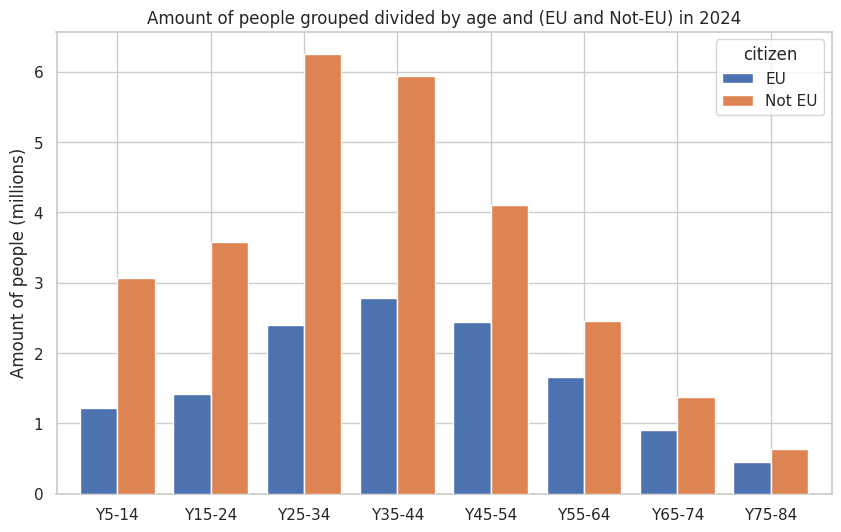

In [ ]:
##Graph showing the distribution of age groups of EU and non-EU migrants in 2024 year

#############################   URL of database
urlEu_Ages = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/eu_not_euGeneral_by_ages1.csv"

#############################  Data cleaning and filtering

df_by_ages_cship = (pd.read_csv(urlEu_Ages, usecols=['age', 'citizen', 'OBS_VALUE','TIME_PERIOD'])
                    .assign(OBS_VALUE_milion=lambda df: df['OBS_VALUE'] / 1000000))
df_by_ages_cship = df_by_ages_cship.query('TIME_PERIOD == 2024')
df_by_ages_cship = pd.concat([df_by_ages_cship.query('age == "Y5-9"'),
                               df_by_ages_cship[df_by_ages_cship['age'] != 'Y5-9']])

df_by_ages_cship = df_by_ages_cship[['age', 'citizen', 'OBS_VALUE', 'OBS_VALUE_milion']]


df_by_ages_cs_eu = df_by_ages_cship.query('citizen == "EU27_2020_FOR"')
df_by_ages_cs_noteu = df_by_ages_cship.query('citizen == "FOR_STLS"')
for i in range(5, 80, 10):
  df_by_ages_cs_eu.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
  df_by_ages_cs_eu.iloc[int(i/5), 0] = f'Y{i}-{i+9}'
  df_by_ages_cs_noteu.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
  df_by_ages_cs_noteu.iloc[int(i/5), 0] = f'Y{i}-{i+9}'


df_by_ages_cship = pd.concat([df_by_ages_cs_eu, df_by_ages_cs_noteu])


df_by_ages_cship = (df_by_ages_cship
                     .groupby(by=['age', 'citizen'])['OBS_VALUE_milion']
                     .sum()
                     .reset_index())

df_by_ages_cship = pd.concat([df_by_ages_cship.query('age == "Y5-14"'),
                               df_by_ages_cship[df_by_ages_cship['age'] != 'Y5-14']])

df_by_ages_cship = df_by_ages_cship.pivot(index='age', columns='citizen', values='OBS_VALUE_milion').reset_index()

df_by_ages_cship['Not EU'] = df_by_ages_cship['FOR_STLS'] - df_by_ages_cship['EU27_2020_FOR']
df_by_ages_cship = df_by_ages_cship[['age', 'EU27_2020_FOR', 'Not EU']]
df_by_ages_cship = pd.concat([
    df_by_ages_cship.query('age == "Y5-14"'),
    df_by_ages_cship[df_by_ages_cship['age'] != 'Y5-14']
])
df_by_ages_cship = df_by_ages_cship.rename(columns={'EU27_2020_FOR':'EU'})
df_by_ages_cship = df_by_ages_cship.reset_index(drop=True)
df_by_ages_cship = df_by_ages_cship.iloc[0:8]
df_by_ages_cship = df_by_ages_cship.set_index('age')
display(df_by_ages_cship)
############################# Create a graf
ax = df_by_ages_cship.plot(
    kind='bar',
    figsize=(10, 6),
    width=0.8,
    zorder=3
)
ax.set_title('Amount of people grouped divided by age and (EU and Not-EU) in 2024')
ax.set_xlabel('')
ax.set_ylabel('Amount of people (millions)')
ax.grid(True, axis='y', zorder=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
pass

sex,age,F,M,Total
0,Y5-14,1.507853,1.603709,3.111562
1,Y15-24,2.024620,2.385301,4.409921
2,Y25-34,4.094244,4.553402,8.647646
3,Y35-44,4.284807,4.442867,8.727674
4,Y45-54,3.223407,3.327655,6.551062
5,Y55-64,2.078274,2.035540,4.113814
6,Y65-74,1.249516,1.035163,2.284679
7,Y75-84,0.570274,0.519778,1.090052


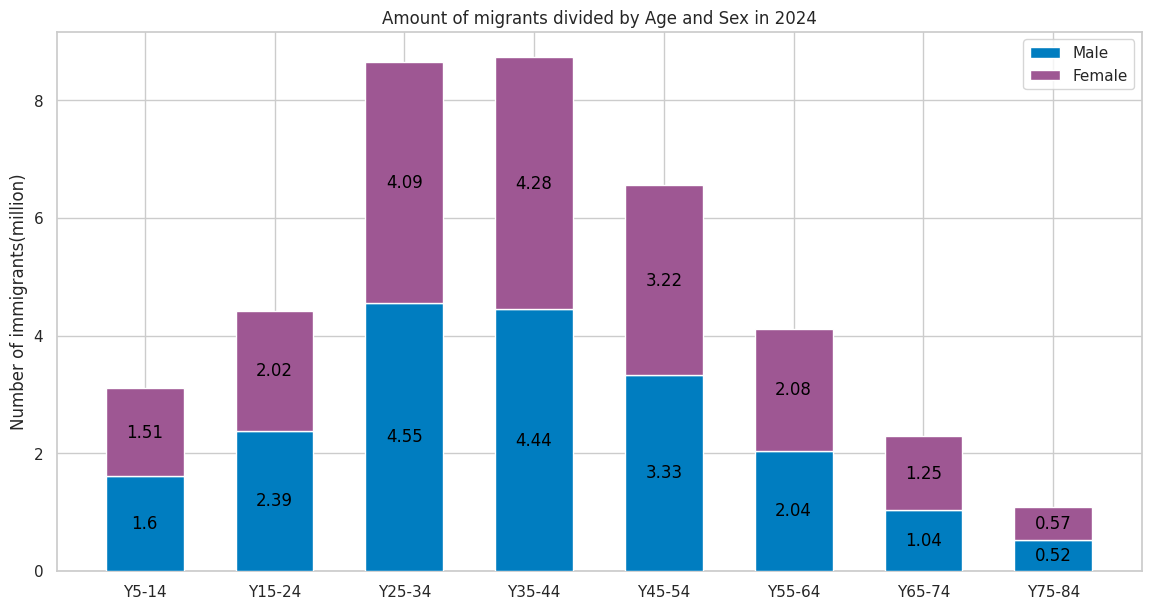

In [ ]:
# Graph describing the distribution of migrants into groups by age and state in EU
############################# URL of database

url2 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/age_data_2.csv"
############################# Data cleaning and filtering

df_by_ages_gender = (pd.read_csv(url2, usecols=['age', 'sex', 'OBS_VALUE', 'TIME_PERIOD'])
                    .query('TIME_PERIOD == 2024 & sex != "T"')
                    .assign(OBS_VALUE_milion=lambda df: df['OBS_VALUE'] / 1000000)
                    .groupby(['age', 'sex'])['OBS_VALUE_milion']
                    .sum()
                    .reset_index())
df_by_ages_gender  = (df_by_ages_gender
                      .query('age!="Y15-64"').iloc[:-6,:]
                      .sort_values(by='age'))
df_by_ages_gender = pd.concat([df_by_ages_gender.query('age == "Y5-9"'),
                               df_by_ages_gender[df_by_ages_gender['age'] != 'Y5-9']])
df_by_ages_gender_men = df_by_ages_gender.query('sex == "M"')
df_by_ages_gender_women = df_by_ages_gender.query('sex == "F"')


for i in range(5, 80, 10):
    df_by_ages_gender_men.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
    df_by_ages_gender_men.iloc[int(i/5), 0] = f'Y{i}-{i+9}'
    df_by_ages_gender_women.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
    df_by_ages_gender_women.iloc[int(i/5), 0] = f'Y{i}-{i+9}'


df_by_ages_gender = pd.concat([df_by_ages_gender_men, df_by_ages_gender_women])
df_by_ages_gender = (df_by_ages_gender
                     .groupby(by=['age', 'sex'])['OBS_VALUE_milion']
                     .sum()
                     .reset_index())
df_by_ages_gender = pd.concat([df_by_ages_gender.query('age == "Y5-14"'),
                               df_by_ages_gender[df_by_ages_gender['age'] != 'Y5-14']])

df_by_ages_gender_wide = df_by_ages_gender.pivot(index='age', columns='sex', values='OBS_VALUE_milion').reset_index()
df_by_ages_gender_wide['Total'] = df_by_ages_gender_wide['M'] + df_by_ages_gender_wide['F']
row = df_by_ages_gender_wide[df_by_ages_gender_wide['age'] == 'Y5-14']
df_by_ages_gender_wide = df_by_ages_gender_wide[df_by_ages_gender_wide['age'] != 'Y5-14']
df_by_ages_gender_wide = pd.concat([row, df_by_ages_gender_wide], ignore_index=True)
dict_by_ages_gender = {
    'Male': df_by_ages_gender_wide['M'],
    'Female': df_by_ages_gender_wide['F'],
}
width = 0.6
############################# Creating graf
fig, ax = plt.subplots(figsize=(14, 7))
bottom = np.zeros(len(df_by_ages_gender_wide['age']))
display(df_by_ages_gender_wide)
for sex, count in dict_by_ages_gender.items():
    if sex == 'Male':
      p = ax.bar(df_by_ages_gender_wide['age'], count, width, label=sex, bottom=bottom, color='#007dc0', zorder=3)
    else:
      p = ax.bar(df_by_ages_gender_wide['age'], count, width, label=sex, bottom=bottom, color='#9e5793', zorder=3)
    bottom += count

    rounded_counts = [str(round(val, 2)) for val in count]
    ax.bar_label(p, labels=rounded_counts, label_type='center', color='black')


ax.set_title('Amount of migrants divided by Age and Sex in 2024')
ax.set_ylabel('Number of immigrants(million)')
ax.grid(True, axis='y', zorder=0)
ax.legend()
pass

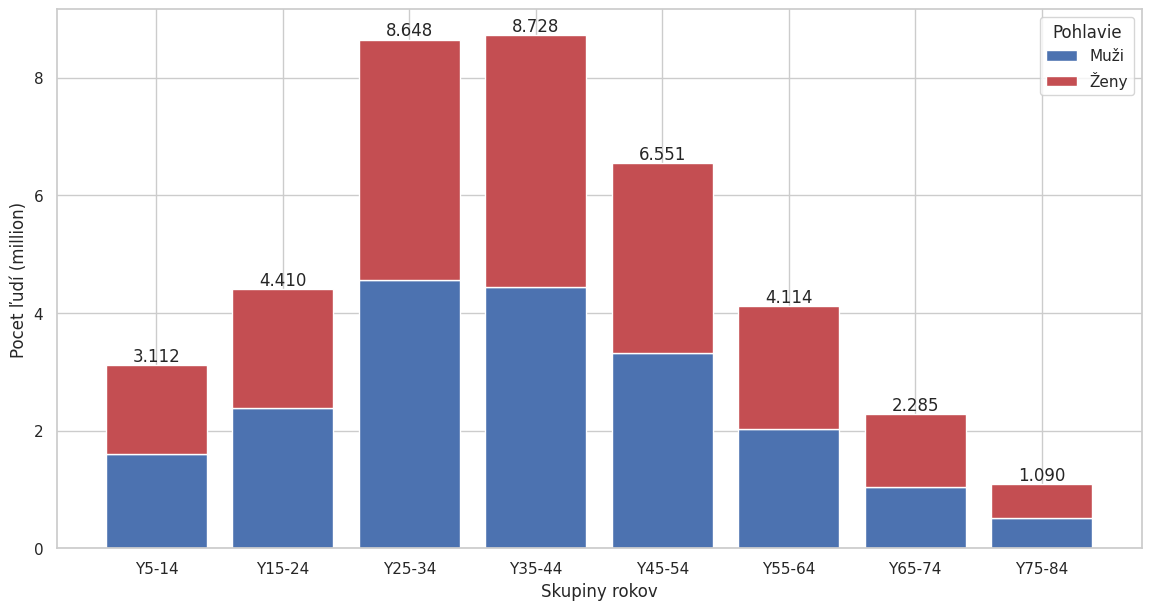

In [ ]:


df_by_ages_gender_men = df_by_ages_gender.query('sex == "M"')
df_by_ages_gender_women = df_by_ages_gender.query('sex == "F"')

fig, axes = plt.subplots(figsize=(14, 7))

male_plot = axes.bar(df_by_ages_gender_men['age'], df_by_ages_gender_men['OBS_VALUE_milion'],
                     color='b',)
female_plot = axes.bar(df_by_ages_gender_women['age'], df_by_ages_gender_women['OBS_VALUE_milion'],
                       bottom=df_by_ages_gender_men['OBS_VALUE_milion'], color='r')

axes.set_ylabel('Pocet ľudí (million)')
axes.set_xlabel('Skupiny rokov')
axes.legend(["Muži", "Ženy"], title='Pohlavie', loc="upper right")
axes.bar_label(female_plot, fmt='%.3f')




df_by_ages_gender_wide = df_by_ages_gender.pivot(index='age', columns='sex', values='OBS_VALUE_milion').reset_index()
df_by_ages_gender_wide['Total'] = df_by_ages_gender_wide['M'] + df_by_ages_gender_wide['F']
row = df_by_ages_gender_wide[df_by_ages_gender_wide['age'] == 'Y5-14']
df_by_ages_gender_wide = df_by_ages_gender_wide[df_by_ages_gender_wide['age'] != 'Y5-14']
df_by_ages_gender_wide = pd.concat([row, df_by_ages_gender_wide], ignore_index=True)
dict_by_ages_gender = {
    'Male': df_by_ages_gender_wide['M'],
    'Female': df_by_ages_gender_wide['F'],
}
width = 0.6  # the width of the bars: can also be len(x) sequence






,Country of citizenship,Geopolitical entity (reporting),OBS_VALUE
18,Türkiye,Germany,1391800
20,Romania,Italy,1073196
21,Ukraine,Germany,974322
22,Morocco,Spain,920693
23,Syria,Germany,879823
...,...,...,...
3564,Chad,Hungary,0
3533,Chad,Estonia,0
3534,Central African Republic,Lithuania,0
3535,Central African Republic,Latvia,0


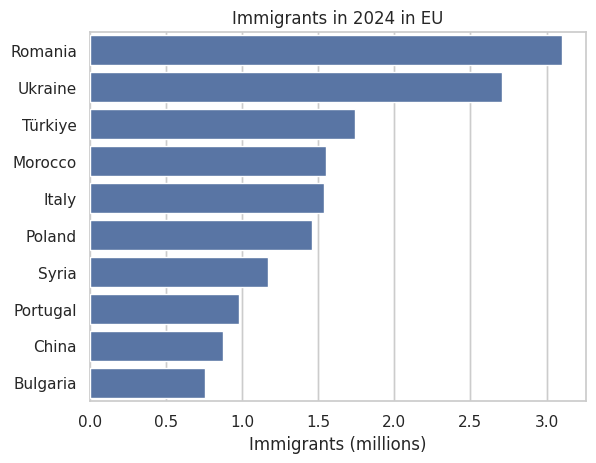

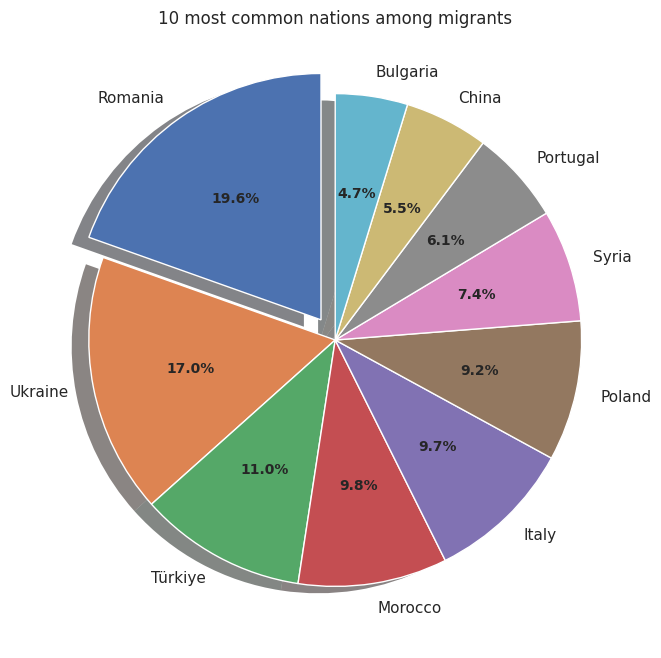

In [ ]:
#хто саме іммугрує з яких країн
url3 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/total_reporty.csv"
data_full_immigration_by_citizen = pd.read_csv(url3, usecols=['Country of citizenship', 'sex','Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE']).query("TIME_PERIOD == 2024")

#кількість іммігрантів у 2024 , та без внутрішної імміграції
data_full_immigration_by_citizen = (data_full_immigration_by_citizen.groupby(['Country of citizenship','Geopolitical entity (reporting)'])['OBS_VALUE']
                                    .sum()
                                    .sort_values(ascending=False)
                                    .reset_index())

data_full_immigration_by_citizen = data_full_immigration_by_citizen[data_full_immigration_by_citizen['Country of citizenship'] != data_full_immigration_by_citizen['Geopolitical entity (reporting)']]
data_full_immigration_by_citizen = data_full_immigration_by_citizen.sort_values(ascending=False,by='OBS_VALUE')

display(data_full_immigration_by_citizen)
### data_full_immigration_by_citizen це датасет получаться з іммігрантами які проживають у країні яка репортить у 2024 році.

data_full_by_citizen = data_full_immigration_by_citizen.groupby('Country of citizenship')['OBS_VALUE'].sum().sort_values(ascending=False)

### data_full_by_citizen цей датасет показує нам кількість усіх громадян певного громадянства у ЄС , які прожвивють не у своїй країні
pre_bar_plot = data_full_by_citizen.head(10)/ 1000000

sns.barplot(pre_bar_plot, orient='h', zorder=3)
plt.xlabel('Immigrants (millions)')
plt.ylabel('')
plt.title('Immigrants in 2024 in EU')
for i in range(5, 35, 5):
  plt.axvline(x=i/10, color='lightgray', linewidth=1, zorder=0)

fig, ax = plt.subplots(figsize=(8, 8))

explodes = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

wedges, texts, autotexts = ax.pie(
    pre_bar_plot,
    labels=pre_bar_plot.index,
    autopct='%1.1f%%',
    startangle=90,
    explode=explodes,
    shadow={'ox': -0.05, 'edgecolor': 'none', 'shade': 0.9},
)

for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

ax.set_title('10 most common nations among migrants')
pass


In [ ]:

plt.show()

['Türkiye', 'Ukraine', 'Syria', 'Romania', 'Poland']

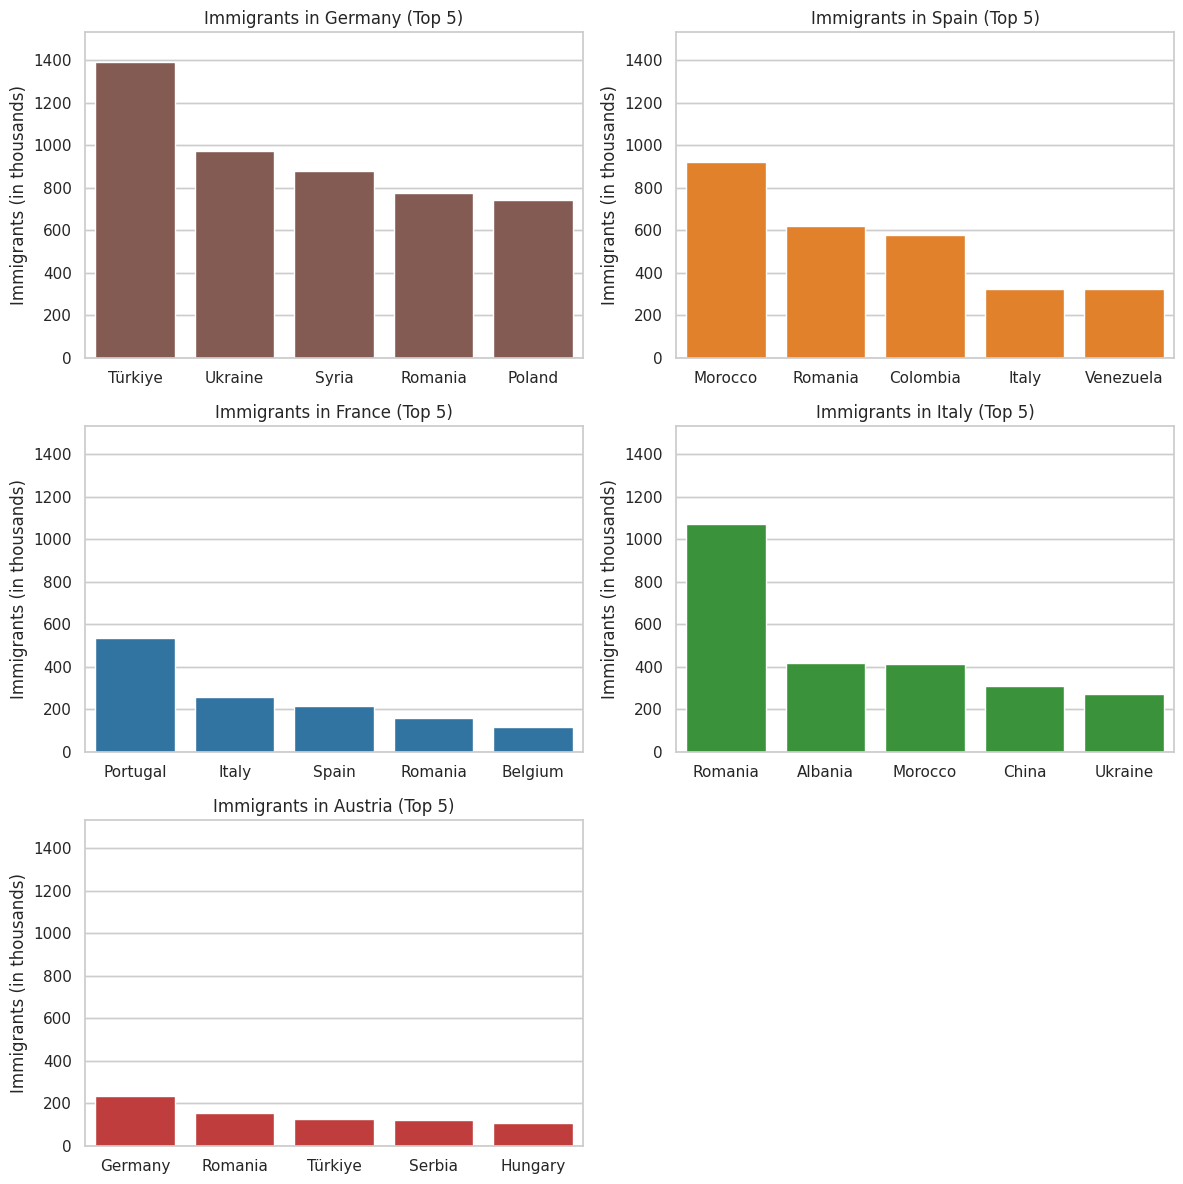

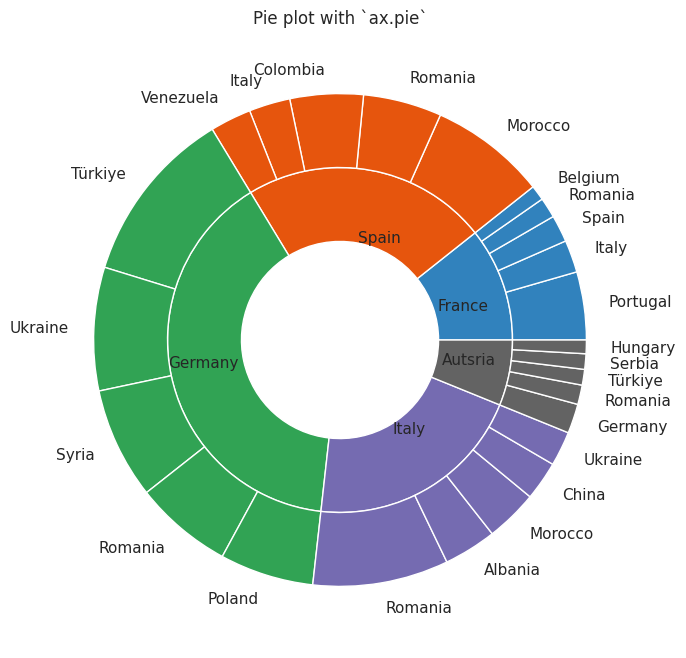

In [ ]:
data_full_immigration_by_Germany =data_full_immigration_by_citizen[data_full_immigration_by_citizen['Geopolitical entity (reporting)']=='Germany'].sort_values(by='OBS_VALUE',ascending=False)
data_full_immigration_by_Italii = data_full_immigration_by_citizen[data_full_immigration_by_citizen['Geopolitical entity (reporting)']=='Italy'].sort_values(by='OBS_VALUE',ascending=False)
data_full_immigration_by_Austria =data_full_immigration_by_citizen[data_full_immigration_by_citizen['Geopolitical entity (reporting)']=='Austria'].sort_values(by='OBS_VALUE',ascending=False)
data_full_immigration_by_Spain =data_full_immigration_by_citizen[data_full_immigration_by_citizen['Geopolitical entity (reporting)']=='Spain'].sort_values(by='OBS_VALUE',ascending=False)
data_full_immigration_by_French =data_full_immigration_by_citizen[data_full_immigration_by_citizen['Geopolitical entity (reporting)']=='France'].sort_values(by='OBS_VALUE',ascending=False)

data_full_immigration_by_Germany['OBS_VALUE'] = data_full_immigration_by_Germany['OBS_VALUE'] / 1_000
data_full_immigration_by_Italii['OBS_VALUE'] = data_full_immigration_by_Italii['OBS_VALUE'] / 1_000
data_full_immigration_by_Austria['OBS_VALUE'] = data_full_immigration_by_Austria['OBS_VALUE'] / 1_000
data_full_immigration_by_Spain['OBS_VALUE'] = data_full_immigration_by_Spain['OBS_VALUE'] / 1_000
data_full_immigration_by_French['OBS_VALUE'] = data_full_immigration_by_French['OBS_VALUE'] / 1_000

fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 рядки, 2 стовпці підграфіків


max_y = 0
for country in [data_full_immigration_by_Germany, data_full_immigration_by_Spain, data_full_immigration_by_French, data_full_immigration_by_Italii, data_full_immigration_by_Austria]:
    value = country.iloc[0]['OBS_VALUE']
    if value > max_y:
        max_y = value



# Germany
sns.barplot(data=data_full_immigration_by_Germany.head(5), x='Country of citizenship', y='OBS_VALUE', ax=axes[0, 0], color='#8c564b')
axes[0, 0].set_title('Immigrants in Germany (Top 5)')
axes[0, 0].set_ylabel('Immigrants (in thousands)')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylim(0, max_y*1.1)
for y in np.arange(0, max_y*1.1, 200):
    axes[0, 0].axhline(y=y, color='lightgray', linewidth=1, zorder=0)
# Spain
sns.barplot(data=data_full_immigration_by_Spain.head(5), x='Country of citizenship', y='OBS_VALUE', ax=axes[0, 1], color='#ff7f0e')
axes[0, 1].set_title('Immigrants in Spain (Top 5)')
axes[0, 1].set_ylabel('Immigrants (in thousands)')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylim(0, max_y*1.1)
for y in np.arange(0, max_y*1.1, 200):
    axes[0, 1].axhline(y=y, color='lightgray', linewidth=1, zorder=0)
# France
sns.barplot(data=data_full_immigration_by_French.head(5), x='Country of citizenship', y='OBS_VALUE', ax=axes[1, 0], color='#1f77b4')
axes[1, 0].set_title('Immigrants in France (Top 5)')
axes[1, 0].set_ylabel('Immigrants (in thousands)')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylim(0, max_y*1.1)
for y in np.arange(0, max_y*1.1, 200):
    axes[1, 0].axhline(y=y, color='lightgray', linewidth=1, zorder=0)
fig.delaxes(axes[2, 1])
# Italy
sns.barplot(data=data_full_immigration_by_Italii.head(5), x='Country of citizenship', y='OBS_VALUE', ax=axes[1, 1], color='#2ca02c')
axes[1, 1].set_title('Immigrants in Italy (Top 5)')
axes[1, 1].set_ylabel('Immigrants (in thousands)')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylim(0, max_y*1.1)
for y in np.arange(0, max_y*1.1, 200):
    axes[1, 1].axhline(y=y, color='lightgray', linewidth=1, zorder=0)
# Austria
sns.barplot(data=data_full_immigration_by_Austria.head(5), x='Country of citizenship', y='OBS_VALUE', ax=axes[2, 0], color='#d62728')
axes[2, 0].set_title('Immigrants in Austria (Top 5)')
axes[2, 0].set_ylabel('Immigrants (in thousands)')
axes[2, 0].set_xlabel('')
axes[2, 0].set_ylim(0, max_y*1.1)
for y in np.arange(0, max_y*1.1, 200):
    axes[2, 0].axhline(y=y, color='lightgray', linewidth=1, zorder=0)


plt.tight_layout()

###Yarik robit
display()
pie_plot_data_Germany = list(data_full_immigration_by_Germany['OBS_VALUE'])[:5]
pie_plot_data_Spain = list(data_full_immigration_by_Spain['OBS_VALUE'])[:5]
pie_plot_data_France = list(data_full_immigration_by_French['OBS_VALUE'])[:5]
pie_plot_data_Italy = list(data_full_immigration_by_Italii['OBS_VALUE'])[:5]
pie_plot_data_Austria = list(data_full_immigration_by_Austria['OBS_VALUE'])[:5]

fig, ax = plt.subplots(figsize=(8, 8))

size = 0.3
vals = np.array([pie_plot_data_France, pie_plot_data_Spain,
 pie_plot_data_Germany, pie_plot_data_Italy, pie_plot_data_Austria])

tab20c = plt.color_sequences["tab20c"]
cmap = plt.get_cmap("tab20c")
group_colors = [cmap(i * 4) for i in range(len(vals))]
inner_colors = group_colors
outer_colors = []
for i in range(len(vals)):
    outer_colors.extend([group_colors[i]] * len(vals[i]))
inner_labels = ['France', 'Spain', 'Germany', 'Italy', 'Autsria']###countries_highest_number_immigrates
display(list(data_full_immigration_by_Germany['Country of citizenship'])[:5])
outer_labels = (
    list(data_full_immigration_by_French['Country of citizenship'])[:5] +
    list(data_full_immigration_by_Spain['Country of citizenship'])[:5] +
    list(data_full_immigration_by_Germany['Country of citizenship'])[:5] +
    list(data_full_immigration_by_Italii['Country of citizenship'])[:5] +
    list(data_full_immigration_by_Austria['Country of citizenship'])[:5]
)

ax.pie(vals.sum(axis=1), radius=1-size, colors = inner_colors,
       labels=inner_labels,
       labeldistance=0.6,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1, colors = outer_colors,
       labels=outer_labels,
       #autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

###

plt.show()

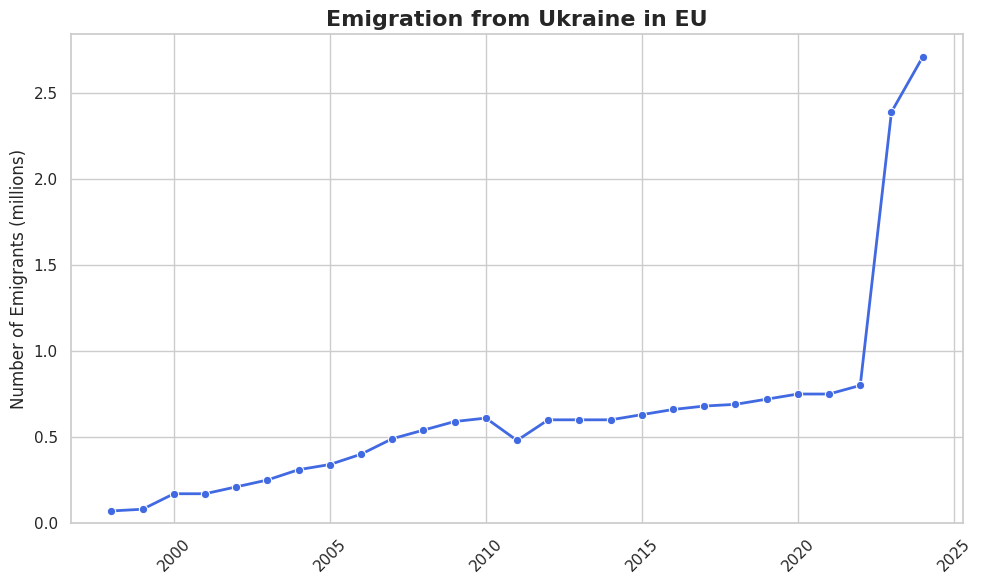

In [ ]:
##Ukraine
url_ua = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/Ukraine.csv"
Ukraine = pd.read_csv(url_ua, usecols=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE', 'age', 'sex']) \
             .query('age == "TOTAL" and sex == "T"') \
             .drop(['age', 'sex'], axis=1)
Ukraine_by_time = Ukraine.groupby('TIME_PERIOD')['OBS_VALUE'].sum().reset_index()
Ukraine_by_time['OBS_VALUE'] = (Ukraine_by_time['OBS_VALUE'] / 1_000_000).round(2)
plt.figure(figsize=(10, 6))
sns.lineplot(data=Ukraine_by_time, x='TIME_PERIOD', y='OBS_VALUE', marker='o', linewidth=2, color='royalblue')

plt.title("Emigration from Ukraine in EU", fontsize=16, fontweight='bold')
plt.ylabel("Number of Emigrants (millions)", fontsize=12)
plt.xlabel("")
plt.xticks(rotation=45)


plt.ylim(0,)
plt.tight_layout()
plt.show()

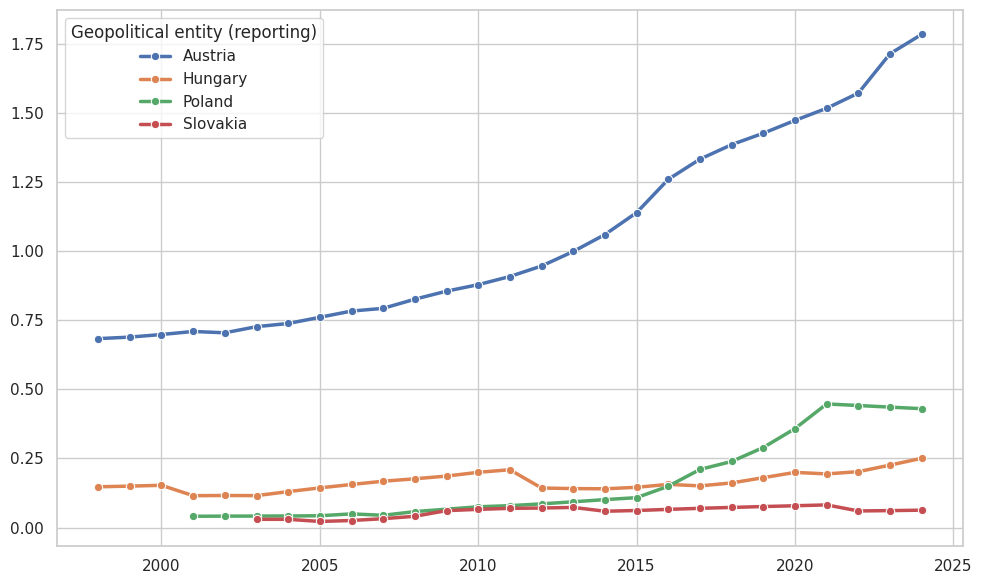

In [ ]:
# Slovakia
urls = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/PreSLovak_neighborhood.csv"
Slovak_and_iny = pd.read_csv(urls,usecols=['citizen','Geopolitical entity (reporting)','TIME_PERIOD','OBS_VALUE'])
Slovak_and_iny = Slovak_and_iny.query("`Geopolitical entity (reporting)` in ['Slovakia', 'Hungary', 'Poland', 'Austria']")
Slovak_and_iny['OBS_VALUE'] = Slovak_and_iny['OBS_VALUE'] / 1000000
fig, axi = plt.subplots(figsize=(10, 6))

sns.lineplot(data=Slovak_and_iny, x='TIME_PERIOD', y='OBS_VALUE', marker='o',hue='Geopolitical entity (reporting)', linewidth=2.5)

plt.title('', fontsize=16)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()
pass

Text(0, 0.5, '')

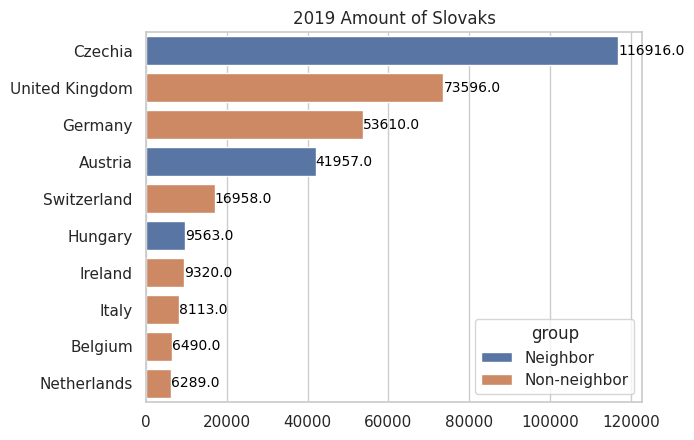

In [ ]:
urls_SL = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/Slovaki_ds.csv"
Slovakian = pd.read_csv(urls_SL,usecols=['citizen','Geopolitical entity (reporting)','TIME_PERIOD','OBS_VALUE'])
# 2019 бо у Великобританії 2019 уйшла а там є найбільше словаків топ 1-2 по кількості , але з 2017-2018 почао падати жоско а з 2020 уже логічо даних немає
years_of_interest = [2019,2024]
Slovakian1= Slovakian[Slovakian['TIME_PERIOD'].isin(years_of_interest)]
#Slovakian_avg_5 = Slovakian1.groupby('Geopolitical entity (reporting)', as_index=False)['OBS_VALUE']
#Slovakian_avg_5 = Slovakian_avg_5.rename(columns={'OBS_VALUE': '6_year_avg'})
#Slovakian_avg_5['6_year_avg'] = Slovakian_avg_5['6_year_avg'].round(0).astype(int)
Slovakian1 = Slovakian1.sort_values(by='OBS_VALUE', ascending=False)
poland_data = Slovakian1[Slovakian1['Geopolitical entity (reporting)'] == 'Poland']
# Топ-10 країн
top_10 = Slovakian1.query("TIME_PERIOD == 2019").head(10)

top_10 = top_10.sort_values(by='OBS_VALUE', ascending=False)
neighbors = ['Poland', 'Czechia', 'Austria', 'Hungary']
top_10['group'] = Slovakian1['Geopolitical entity (reporting)'].apply(lambda x: 'Neighbor' if x in neighbors else 'Non-neighbor')
axa = sns.barplot(data=top_10
, y='Geopolitical entity (reporting)', x='OBS_VALUE',hue='group')
for bar in axa.patches:
  width = bar.get_width()
  if width != 0:
    axa.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
                f'{width:.1f}', va='center', ha='left', fontsize=10, color='black')

axa.set_title('2019 Amount of Slovaks')
axa.set_xlabel("")
axa.set_ylabel("")

Text(0, 0.5, '')

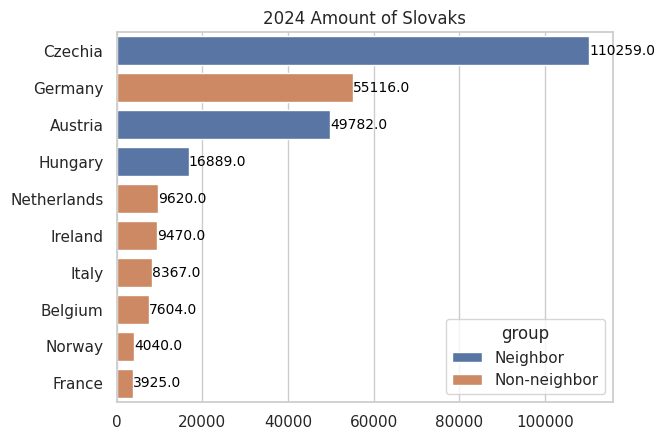

In [ ]:
data_2024 = Slovakian[Slovakian['TIME_PERIOD'] == 2024]
data_2024 = data_2024.sort_values(by='OBS_VALUE', ascending=False)

poland_data_2024 = data_2024[data_2024['Geopolitical entity (reporting)'] == 'Poland']

top_10_2024 = data_2024.head(10)
top_10_2024 = top_10_2024.sort_values(by='OBS_VALUE', ascending=False)
neighbors = ['Poland', 'Czechia', 'Austria', 'Hungary']
top_10_2024['group'] = top_10_2024['Geopolitical entity (reporting)'].apply(lambda x: 'Neighbor' if x in neighbors else 'Non-neighbor')
axa = sns.barplot(data=top_10_2024, y='Geopolitical entity (reporting)', x='OBS_VALUE', hue='group')
for bar in axa.patches:
    width = bar.get_width()
    if width != 0:
        axa.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
                 f'{width:.1f}', va='center', ha='left', fontsize=10, color='black')

axa.set_title('2024 Amount of Slovaks')
axa.set_xlabel("")
axa.set_ylabel("")

Text(0, 0.5, '')

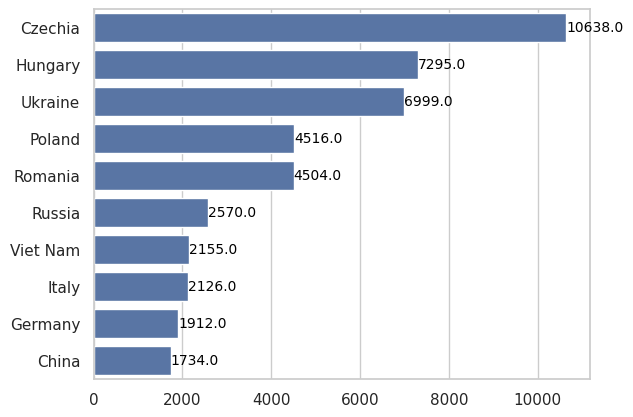

In [ ]:
rls_SL_migrants = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/Migrants_in_Slovak.csv"
Slovakian_migrants = pd.read_csv(rls_SL_migrants,usecols=['Country of citizenship','Geopolitical entity (reporting)','TIME_PERIOD','OBS_VALUE'])
Slovakian_migrants_2024 = Slovakian_migrants.query('TIME_PERIOD == 2024')
Slovakian_migrants_2024 = Slovakian_migrants_2024.sort_values(by='OBS_VALUE',ascending=False)
Slovakian_migrants_2024
dada = sns.barplot(data=Slovakian_migrants_2024.head(10),y='Country of citizenship',x='OBS_VALUE')
for bar in dada.patches:
    width = bar.get_width()
    if width != 0:
        dada.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
                 f'{width:.1f}', va='center', ha='left', fontsize=10, color='black')
dada.set_title('')
dada.set_xlabel("")
dada.set_ylabel("")

### Part 2

#### Data loading

In [ ]:
### --- DATA LOADING --- ###
emigration_whole_url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/refs/heads/main/data/emigration_whole.csv"
emigration_filtered_url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/refs/heads/main/data/emigration_filtered.csv"

immigration_whole_url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/refs/heads/main/data/immigration_whole.csv"
immigration_filtered_url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/refs/heads/main/data/immigration_filtered.csv"

ua_displacement = "https://raw.githubusercontent.com/loveBeatles/datavis_project/refs/heads/main/data/ua_displacement.csv"

# -------------------------------------------------------------------------------------------------------------------------------------

emigration_whole = pd.read_csv(emigration_whole_url)
# emigration_filtered = pd.read_csv(emigration_filtered_url)

immigration_whole = pd.read_csv(immigration_whole_url)
# immigration_filtered = pd.read_csv(immigration_filtered_url)

ua_displacement = pd.read_csv(ua_displacement)
asylum_eurostat = pd.read_csv("data/asylum_eurostat.csv") #!!

**About the data:**

- `emigration_whole` includes a comprehensive dataset from Eurostat with the code `migr_emi1ctz`. It contains information about sex, age categories, and citizenship, spanning the years 1998-2023.
- `immigration_whole` mirrors the structure of `emigration_whole` but focuses on immigrants. The corresponding Eurostat code is `migr_imm1ctz`.
- `emigration_filtered` is a subset of `emigration_whole`, filtered for EU countries starting from 2012. It includes data for total citizenship, age, and sex.
- `immigration_filtered` is the filtered counterpart of `immigration_whole`, containing similar data for immigrants.
- `asylum_eurostat` provides quarterly data (Q1-Q4) from 2008 to 2024. It includes details about sex, age categories, and citizenship.
- `ua_displacement` contains information about Ukrainian asylum-seekers, refugees, returned refugees from 2000 to 2024 year.

#### Data cleaning

In [ ]:
### --- DATA CLEANING --- ###
def clean_migration_data(df):
    """
    Cleans Eurostat migration data by converting it from wide to long format,
    filtering relevant rows, and handling missing values.
    """
    # Rename columns for clarity
    df = df.rename(columns={'geo\\TIME_PERIOD': 'country'})

    # Identify year columns (numeric column names)
    year_columns = [col for col in df.columns if col.isdigit()]

    # Convert from wide to long format
    long_df = pd.melt(
        df,
        id_vars=['country', 'citizen', 'age', 'sex'],
        value_vars=year_columns,
        var_name='year',
        value_name='count'
    )

    # Filter for relevant rows (TOTAL age, TOTAL sex, TOTAL citizen)
    long_df = long_df[
        (long_df['age'] == 'TOTAL') &
        (long_df['sex'] == 'T') &
        (long_df['citizen'] == 'TOTAL')
    ]

    # Convert year to integer and handle missing values in the value column
    long_df['year'] = long_df['year'].astype(int)
    long_df['count'] = pd.to_numeric(
        long_df['count'].replace(':', pd.NA),  # Replace ':' with NaN
        errors='coerce'
    ).fillna(0)  # Fill NaN with 0 for better handling in analysis

    # Drop unnecessary columns to reduce memory usage
    long_df = long_df.drop(columns=['age', 'sex', 'citizen'])

    # Reset index for a clean DataFrame
    long_df = long_df.reset_index(drop=True)
    long_df = long_df.drop_duplicates(subset=['country', 'year', 'count'], keep='first')

    return long_df

In [ ]:
def clean_asylum_data(df):
    """
    Cleans Eurostat asylum data by filtering relevant rows,
    converting from wide to long format,
    """
    # Filter relevant dimensions
    df = df[
        (df['age'] == 'TOTAL') &
        (df['sex'] == 'T') &
        (df['decision'] == 'TOTAL') &
        (~df[r'geo\TIME_PERIOD'].isin(['EU27_2020', 'EU28']))
    ].copy()

    # Identify time columns using regex
    time_columns = [col for col in df.columns if re.match(r'\d{4}-Q[1-4]', col)]

    # Convert from wide to long format
    id_vars = [col for col in df.columns if col not in time_columns]
    df = df.melt(
        id_vars=id_vars,
        var_name='period',
        value_name='asylum_seekers'
    )

    # Extract year and quarter from period
    df[['year', 'quarter']] = df['period'].str.extract(r'(\d{4})-Q(\d)')
    df = df.dropna(subset=['year', 'quarter'])
    df['year'] = df['year'].astype(int)
    df['quarter'] = df['quarter'].astype(int)

    # Convert to datetime (first day of quarter)
    df['date'] = pd.to_datetime(
        df['year'].astype(str) + '-' + (3*df['quarter']-2).astype(str) + '-01'
    )

    # Clean numerical values
    df['asylum_seekers'] = (
        pd.to_numeric(df['asylum_seekers'], errors='coerce')
        .fillna(0)
        .astype(int)
    )

    # Filter time range
    df = df[df['year'].between(2013, 2023)]

    # Country mapping
    country_mapping = {
        'BE': 'Belgium',
        'FR': 'France',
        'LU': 'Luxembourg',
        'NL': 'Netherlands',
        'DE': 'Germany',
        'DK': 'Denmark',
        'IE': 'Ireland',
        'SE': 'Sweden',
        'FI': 'Finland',
        'ES': 'Spain',
        'PT': 'Portugal',
        'IT': 'Italy',
        'MT': 'Malta',
        'EL': 'Greece',
        'CY': 'Cyprus',
        'PL': 'Poland',
        'CZ': 'Czechia',
        'SK': 'Slovakia',
        'HU': 'Hungary',
        'SI': 'Slovenia',
        'HR': 'Croatia',
        'RO': 'Romania',
        'BG': 'Bulgaria',
        'EE': 'Estonia',
        'LV': 'Latvia',
        'LT': 'Lithuania',
        'AT': 'Austria'
    }

    df['country'] = df[r'geo\TIME_PERIOD'].map(country_mapping).fillna('Other')

    # Aggregate to country-year level
    agg_df = df.groupby(['country', 'year'], as_index=False).agg(
        total_asylum_seekers=('asylum_seekers', 'sum'),
        avg_quarterly=('asylum_seekers', 'mean'),
        q25=('asylum_seekers', lambda x: np.quantile(x, 0.25)),
        median=('asylum_seekers', 'median'),
        q75=('asylum_seekers', lambda x: np.quantile(x, 0.75))
    )

    return agg_df

In [ ]:
def clean_ua_displacement(df):
    """Drops unnecessary columns and renames others for clarity."""
    # Drop unnecessary columns
    df.drop(
        columns=[
        'IDPs of concern to UNHCR',
        'Returned IDPss',
        'Stateless persons',
        'Others of concern',
        'Other people in need of international protection',
        'Host Community'],
        inplace=True,
        errors='ignore'
    )

    # Rename columns for clarity
    df.rename(columns={
        'Year': 'year',
        'Country of origin': 'origin_country',
        'Country of origin (ISO)': 'origin_country_iso',
        'Country of asylum': 'asylum_country',
        'Country of asylum (ISO)': 'asylum_country_iso',
        'Refugees under UNHCR\'s mandate': 'refugees',
        'Asylum-seekers': 'asylum_seekers',
        'Returned refugees': 'returned_refugees'
    }, inplace=True)

    # Handle missing or zero values in key columns
    df['refugees'] = df['refugees'].fillna(0).astype(int)
    df['asylum_seekers'] = df['asylum_seekers'].fillna(0).astype(int)
    df['returned_refugees'] = df['returned_refugees'].fillna(0).astype(int)

    # Drop rows with missing country information
    df.dropna(subset=['origin_country', 'asylum_country'], inplace=True)

    # Reset index for a clean DataFrame
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
def clean_ua_immigration(df):
    """
    Cleans and processes Ukrainian immigration data for analysis.
    Returns cleaned DataFrame with all original countries preserved.
    """
    # Store original unique countries before filtering
    original_countries = df['geo\\TIME_PERIOD'].unique().tolist()

    # Filter data for UA citizens, specific sexes, and total age
    filtered = df.query('citizen == "UA" and sex in ["M", "F", "T"] and age == "TOTAL"')

    # Rename and drop unnecessary columns
    processed = (
        filtered.rename(columns={'geo\\TIME_PERIOD': 'country'})
        .drop(columns=['agedef', 'freq', 'unit', 'citizen', 'age'])
    )

    # Melt year columns to long format
    years = [col for col in processed.columns if col.isdigit()]
    melted = processed.melt(
        id_vars=['country', 'sex'],
        value_vars=years,
        var_name='year',
        value_name='immigrants'
    )

    # Create full grid of all possible combinations
    full_grid = pd.MultiIndex.from_product([
        original_countries,
        melted['sex'].unique(),
        melted['year'].unique()
    ], names=['country', 'sex', 'year']).to_frame(index=False)

    # Merge with melted data
    merged = full_grid.merge(
        melted,
        on=['country', 'sex', 'year'],
        how='left'
    )

    # Handle duplicates and NaNs
    final_df = (
        merged
        .groupby(['country', 'sex', 'year'])['immigrants']
        .sum()
        .reset_index()
        .assign(year=lambda x: x['year'].astype(int))
        .assign(immigrants=lambda x: x['immigrants'].fillna(0))
        .sort_values(['country', 'sex', 'year'])
        .reset_index(drop=True)
    )

    return final_df

In [ ]:
immigration_whole_cleaned = clean_migration_data(immigration_whole)
emigration_whole_cleaned = clean_migration_data(emigration_whole)
asylum_eurostat_cleaned = clean_asylum_data(asylum_eurostat)
ua_displacement_cleaned = clean_ua_displacement(ua_displacement)
ua_immigrants = clean_ua_immigration(immigration_whole)

In [ ]:
### --- DATA MERGE --- ###
migration_data = pd.merge(
    immigration_whole_cleaned.rename(columns={'count': 'immigrants'}),
    emigration_whole_cleaned.rename(columns={'count': 'emigrants'}),
    on=['country', 'year'],
    how='outer'
)

# Filter for target countries
target_countries = ['SK', 'AT', 'HU', 'CZ', 'PL']  # Slovakia, Austria, Hungary, Czechia, Poland
migration_data_sk_neighbors = migration_data[migration_data['country'].isin(target_countries)]


In [ ]:
display(emigration_whole_cleaned.sample(10))

,country,year,count
1634,UA,2018,0.0
2002,BG,2023,15227.0
753,SK,2007,1831.0
1396,AM,2015,0.0
1955,UK,2022,0.0
246,DE,2001,606494.0
98,IT,1999,64873.0
361,BY,2002,0.0
722,BG,2007,2958.0
1238,AZ,2013,0.0


In [ ]:
display(immigration_whole_cleaned.sample(10))

,country,year,count
825,CZ,2008,108267.0
1006,LV,2010,4011.0
202,AZ,2000,0.0
1733,EU27_2020,2019,4176776.0
1081,HU,2011,28018.0
1732,ES,2019,750480.0
1827,MD,2020,65167.0
590,IE,2005,102000.0
1890,CY,2021,25473.0
587,FR,2005,0.0


In [ ]:
display(asylum_eurostat_cleaned.sample(10))

,country,year,total_asylum_seekers,avg_quarterly,q25,median,q75
290,Spain,2017,36105,43.816748,0.0,0.0,0.0
86,Estonia,2022,6550,7.949029,0.0,0.0,0.0
184,Lithuania,2021,9775,11.862864,0.0,0.0,0.0
94,Finland,2019,14450,17.536408,0.0,0.0,0.0
303,Sweden,2019,79010,95.885922,0.0,0.0,15.0
190,Luxembourg,2016,3720,4.514563,0.0,0.0,0.0
160,Italy,2019,280450,340.351942,0.0,0.0,25.0
234,Poland,2016,7370,8.944175,0.0,0.0,0.0
72,Denmark,2019,9080,11.019417,0.0,0.0,0.0
147,Ireland,2017,2585,3.137136,0.0,0.0,0.0


In [ ]:
display(migration_data.sample(10))

,country,year,immigrants,emigrants
580,IT,2006,279714.0,58407.0
1071,SK,2007,8624.0,1831.0
1172,UK,2004,518097.0,310389.0
1067,SK,2003,2603.0,1194.0
573,IT,1999,185052.0,64873.0
195,CH,2011,148799.0,96494.0
859,NL,2003,104514.0,68885.0
1149,UA,2007,NaN,0.0
1130,TJ,2014,0.0,0.0
448,FR,2004,0.0,0.0


In [ ]:
display(migration_data_sk_neighbors.sample(10))

,country,year,immigrants,emigrants
1069,SK,2005,5276.0,1873.0
49,AT,2021,118511.0,67299.0
44,AT,2016,129509.0,64428.0
33,AT,2005,114465.0,70133.0
32,AT,2004,122547.0,71721.0
924,PL,2016,208302.0,236441.0
907,PL,1999,7525.0,21536.0
250,CZ,2014,29897.0,28468.0
251,CZ,2015,29602.0,25684.0
234,CZ,1998,0.0,0.0


In [ ]:
display(ua_displacement.sample(10))

,year,origin_country,origin_country_iso,asylum_country,asylum_country_iso,refugees,asylum_seekers,returned_refugees
274,2006,Ukraine,UKR,Italy,ITA,29,0,0
878,2020,Ukraine,UKR,Greece,GRC,158,63,0
623,2016,Ukraine,UKR,Brazil,BRA,7,48,0
144,2001,Ukraine,UKR,Slovakia,SVK,0,6,0
230,2005,Ukraine,UKR,Argentina,ARG,11,11,0
143,2001,Ukraine,UKR,Spain,ESP,54,0,0
704,2017,Ukraine,UKR,Ireland,IRL,110,66,0
500,2014,Ukraine,UKR,Australia,AUS,22,59,0
21,1995,Ukraine,UKR,Spain,ESP,5,0,0
615,2015,Ukraine,UKR,United States of America,USA,1486,3859,0


In [ ]:
display(ua_immigrants.sample(10))

,country,sex,year,immigrants
1173,ES,F,2001,9858.0
2533,MT,M,2009,0.0
460,BE,T,2016,1142.0
2170,LU,T,2010,84.0
1482,HR,F,1998,0.0
156,AT,F,1998,494.0
2840,PT,M,2004,0.0
2058,LT,M,2002,726.0
1943,KG,T,2017,0.0
3670,US,F,2002,0.0


#### Visualization

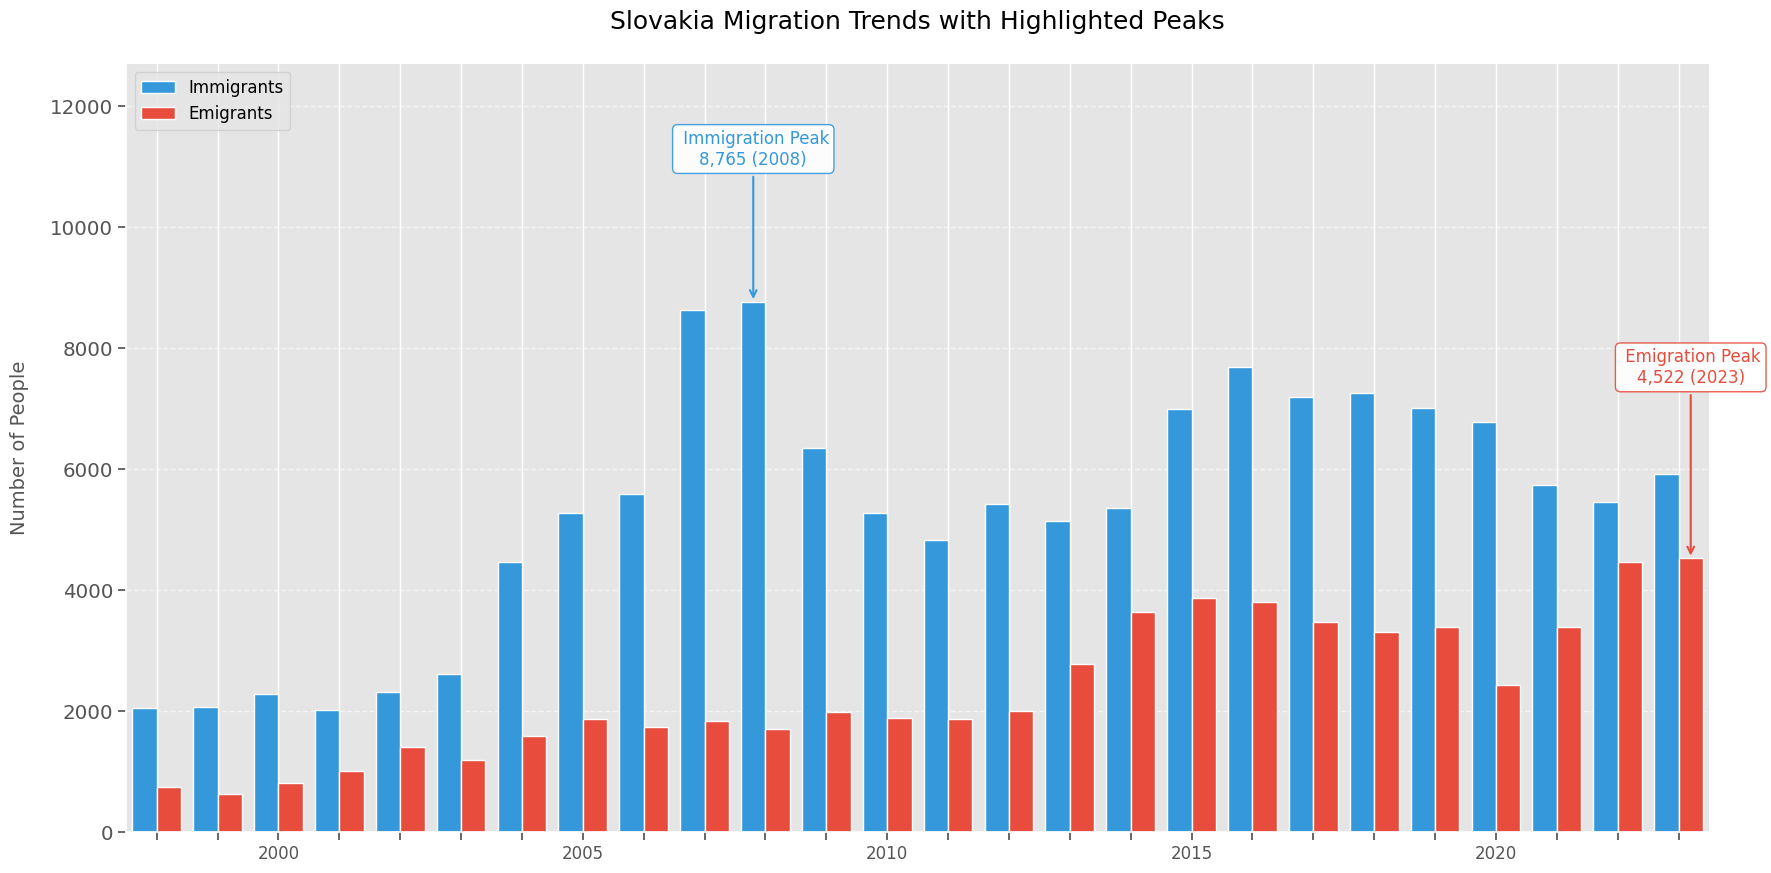

In [ ]:
### --- Slovakia Migration Plot --- ###
def plot_slovakia_migration(data):
    """Migration plot"""

    # Load and prepare data
    sk_data = data[data['country'] == 'SK'].copy()

    sk_data['year'] = sk_data['year'].astype(int)
    sk_data = sk_data.sort_values('year').reset_index(drop=True)

    # Create figure
    fig = plt.figure(figsize=(18, 9))
    ax = plt.gca()

    # Visual parameters
    bar_width = 0.4
    years = sk_data['year'].astype(int)
    x_pos = np.arange(len(years))
    color_imm = '#3498db'
    color_emi = '#e74c3c'

    # Plot bars
    ax.bar(x_pos - bar_width/2, sk_data['immigrants'], bar_width,
          label='Immigrants', color=color_imm, edgecolor='white')
    ax.bar(x_pos + bar_width/2, sk_data['emigrants'], bar_width,
          label='Emigrants', color=color_emi, edgecolor='white')

    # Configure x-axis (5-year intervals)
    xtick_labels = [str(y) if y%5 == 0 else '' for y in years]
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xtick_labels, fontsize=12)

    # Find peak values
    max_imm = sk_data['immigrants'].max()
    max_imm_year = sk_data.loc[sk_data['immigrants'].idxmax(), 'year']
    max_emi = sk_data['emigrants'].max()
    max_emi_year = sk_data.loc[sk_data['emigrants'].idxmax(), 'year']

    # Calculate positions
    imm_idx = sk_data['immigrants'].idxmax()
    emi_idx = sk_data['emigrants'].idxmax()
    imm_x = x_pos[imm_idx] - bar_width/2
    emi_x = x_pos[emi_idx] + bar_width/2

    # Vertical spacing parameters
    y_gap = max(max_imm, max_emi) * 0.18  # 18% of max value

    # Immigration annotation
    ax.annotate(f' Immigration Peak\n{int(max_imm):,} ({max_imm_year})',
                xy=(imm_x, max_imm),
                xytext=(imm_x, max_imm + y_gap*1.4),
                arrowprops=dict(arrowstyle='->', lw=1.5, color=color_imm,
                                connectionstyle='angle3,angleA=0,angleB=90'),
                ha='center', va='bottom', fontsize=12, color=color_imm,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=color_imm, alpha=0.9))

    # Emigration annotation
    ax.annotate(f' Emigration Peak\n{int(max_emi):,} ({max_emi_year})',
                xy=(emi_x, max_emi),
                xytext=(emi_x, max_emi + y_gap*1.8),
                arrowprops=dict(arrowstyle='->', lw=1.5, color=color_emi,
                                connectionstyle='angle3,angleA=0,angleB=90'),
                ha='center', va='bottom', fontsize=12, color=color_emi,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=color_emi, alpha=0.9))

    # Formatting
    ax.set_title('Slovakia Migration Trends with Highlighted Peaks', fontsize=18, pad=25)
    ax.set_ylabel('Number of People', fontsize=14, labelpad=15)
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    ax.legend(frameon=True, fontsize=12, loc='upper left')

    # Set axis limits
    ax.set_ylim(top=max(max_imm, max_emi)*1.45)
    ax.set_xlim(-0.5, len(years)-0.5)

    # Remove spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Save figure
    fig_save(fig, 'img/slovakia_migration_trends.png')

plot_slovakia_migration(migration_data_sk_neighbors)

In [ ]:
display(migration_data_sk_neighbors.query('country == "CZ"').head())

,country,year,immigrants,emigrants
234,CZ,1998,0.0,0.0
235,CZ,1999,0.0,0.0
236,CZ,2000,0.0,0.0
237,CZ,2001,12918.0,21469.0
238,CZ,2002,44679.0,32389.0


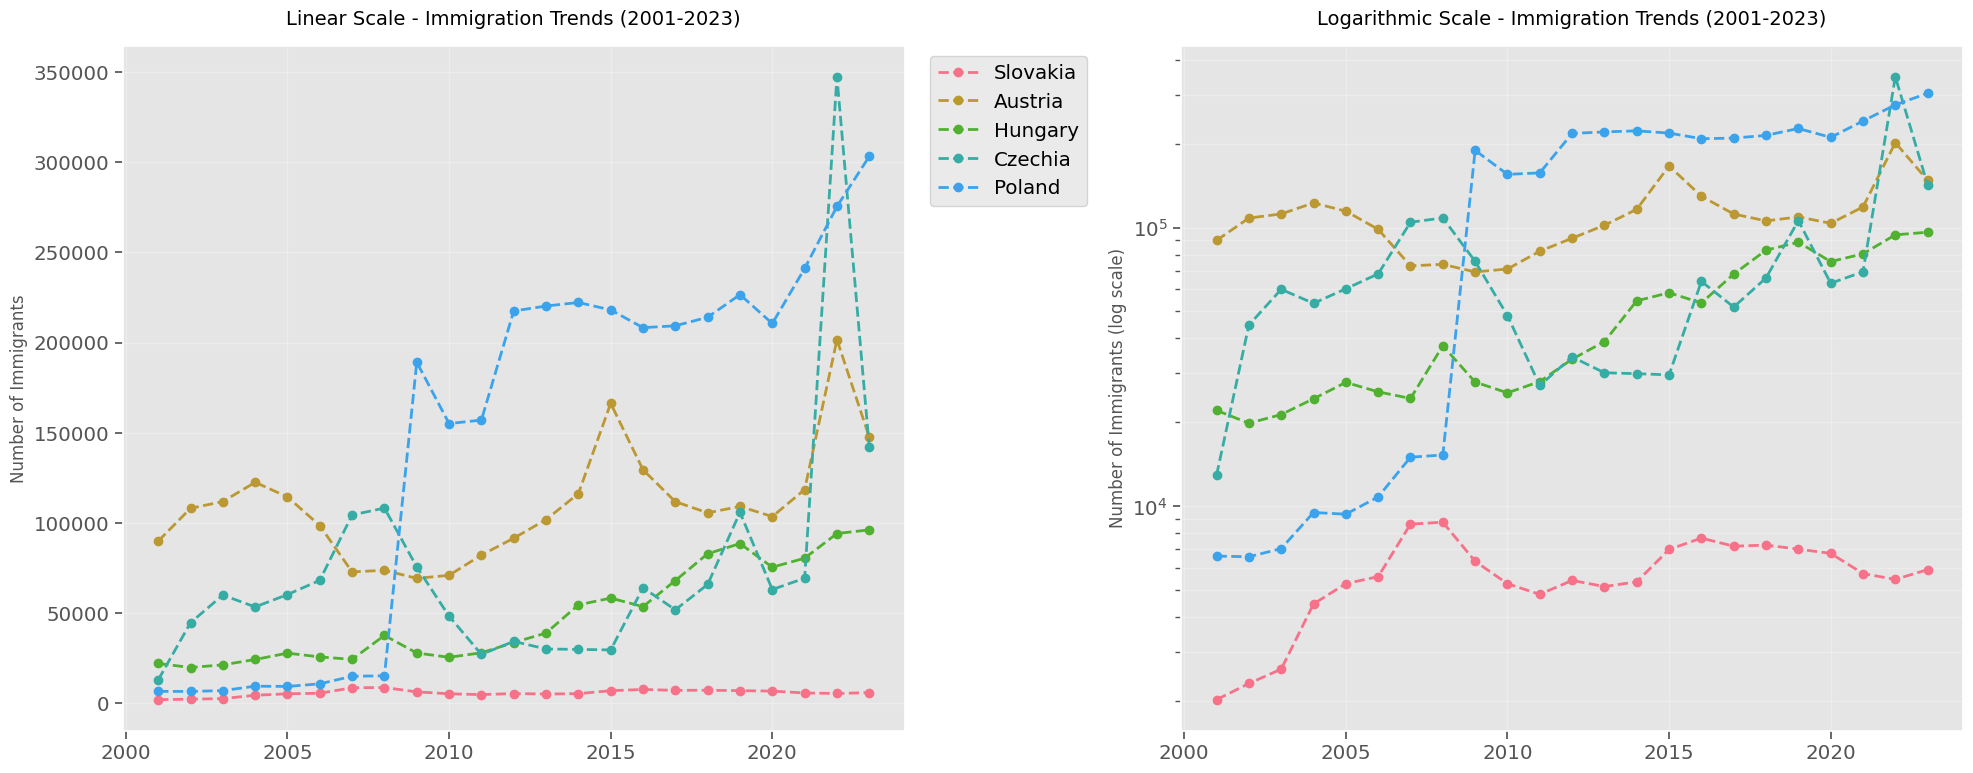

In [ ]:
### --- Neighboring Countries Comparison --- ###
def plot_neighbor_comparison(data):
    """Compare migration in neighboring countries with dual scaling"""

    # Display the data from 2000 year because of missing data in CZ in 1998, 1999, 2000
    data = data.query('year > 2000').copy()

    # Prepare data
    countries = {
        'SK': 'Slovakia',
        'AT': 'Austria',
        'HU': 'Hungary',
        'CZ': 'Czechia',
        'PL': 'Poland'
    }

    # Create dual plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Common styling parameters
    line_style = {'marker': 'o', 'linestyle': '--', 'linewidth': 2, 'markersize': 6}

    # Plot both versions
    for code, name in countries.items():
        country_data = data[data['country'] == code]

        # Linear scale plot
        ax1.plot(
            country_data['year'],
            country_data['immigrants'],
            label=f'{name}',
            **line_style
        )

        # Log scale plot
        ax2.plot(
            country_data['year'],
            country_data['immigrants'],
            label=f'{name}',
            **line_style
        )

    # Configure linear scale plot
    ax1.set_title('Linear Scale - Immigration Trends (2001-2023)', fontsize=14, pad=15)
    ax1.set_ylabel('Number of Immigrants', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Configure log scale plot
    ax2.set_title('Logarithmic Scale - Immigration Trends (2001-2023)', fontsize=14, pad=15)
    ax2.set_ylabel('Number of Immigrants (log scale)', fontsize=12)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, which='both')

    # Adjust layout and save
    plt.tight_layout()
    plt.show()

    # Save figure
    fig_save(fig, 'img/sk_neighbors_comparison_dual_scales.png')


plot_neighbor_comparison(migration_data_sk_neighbors)

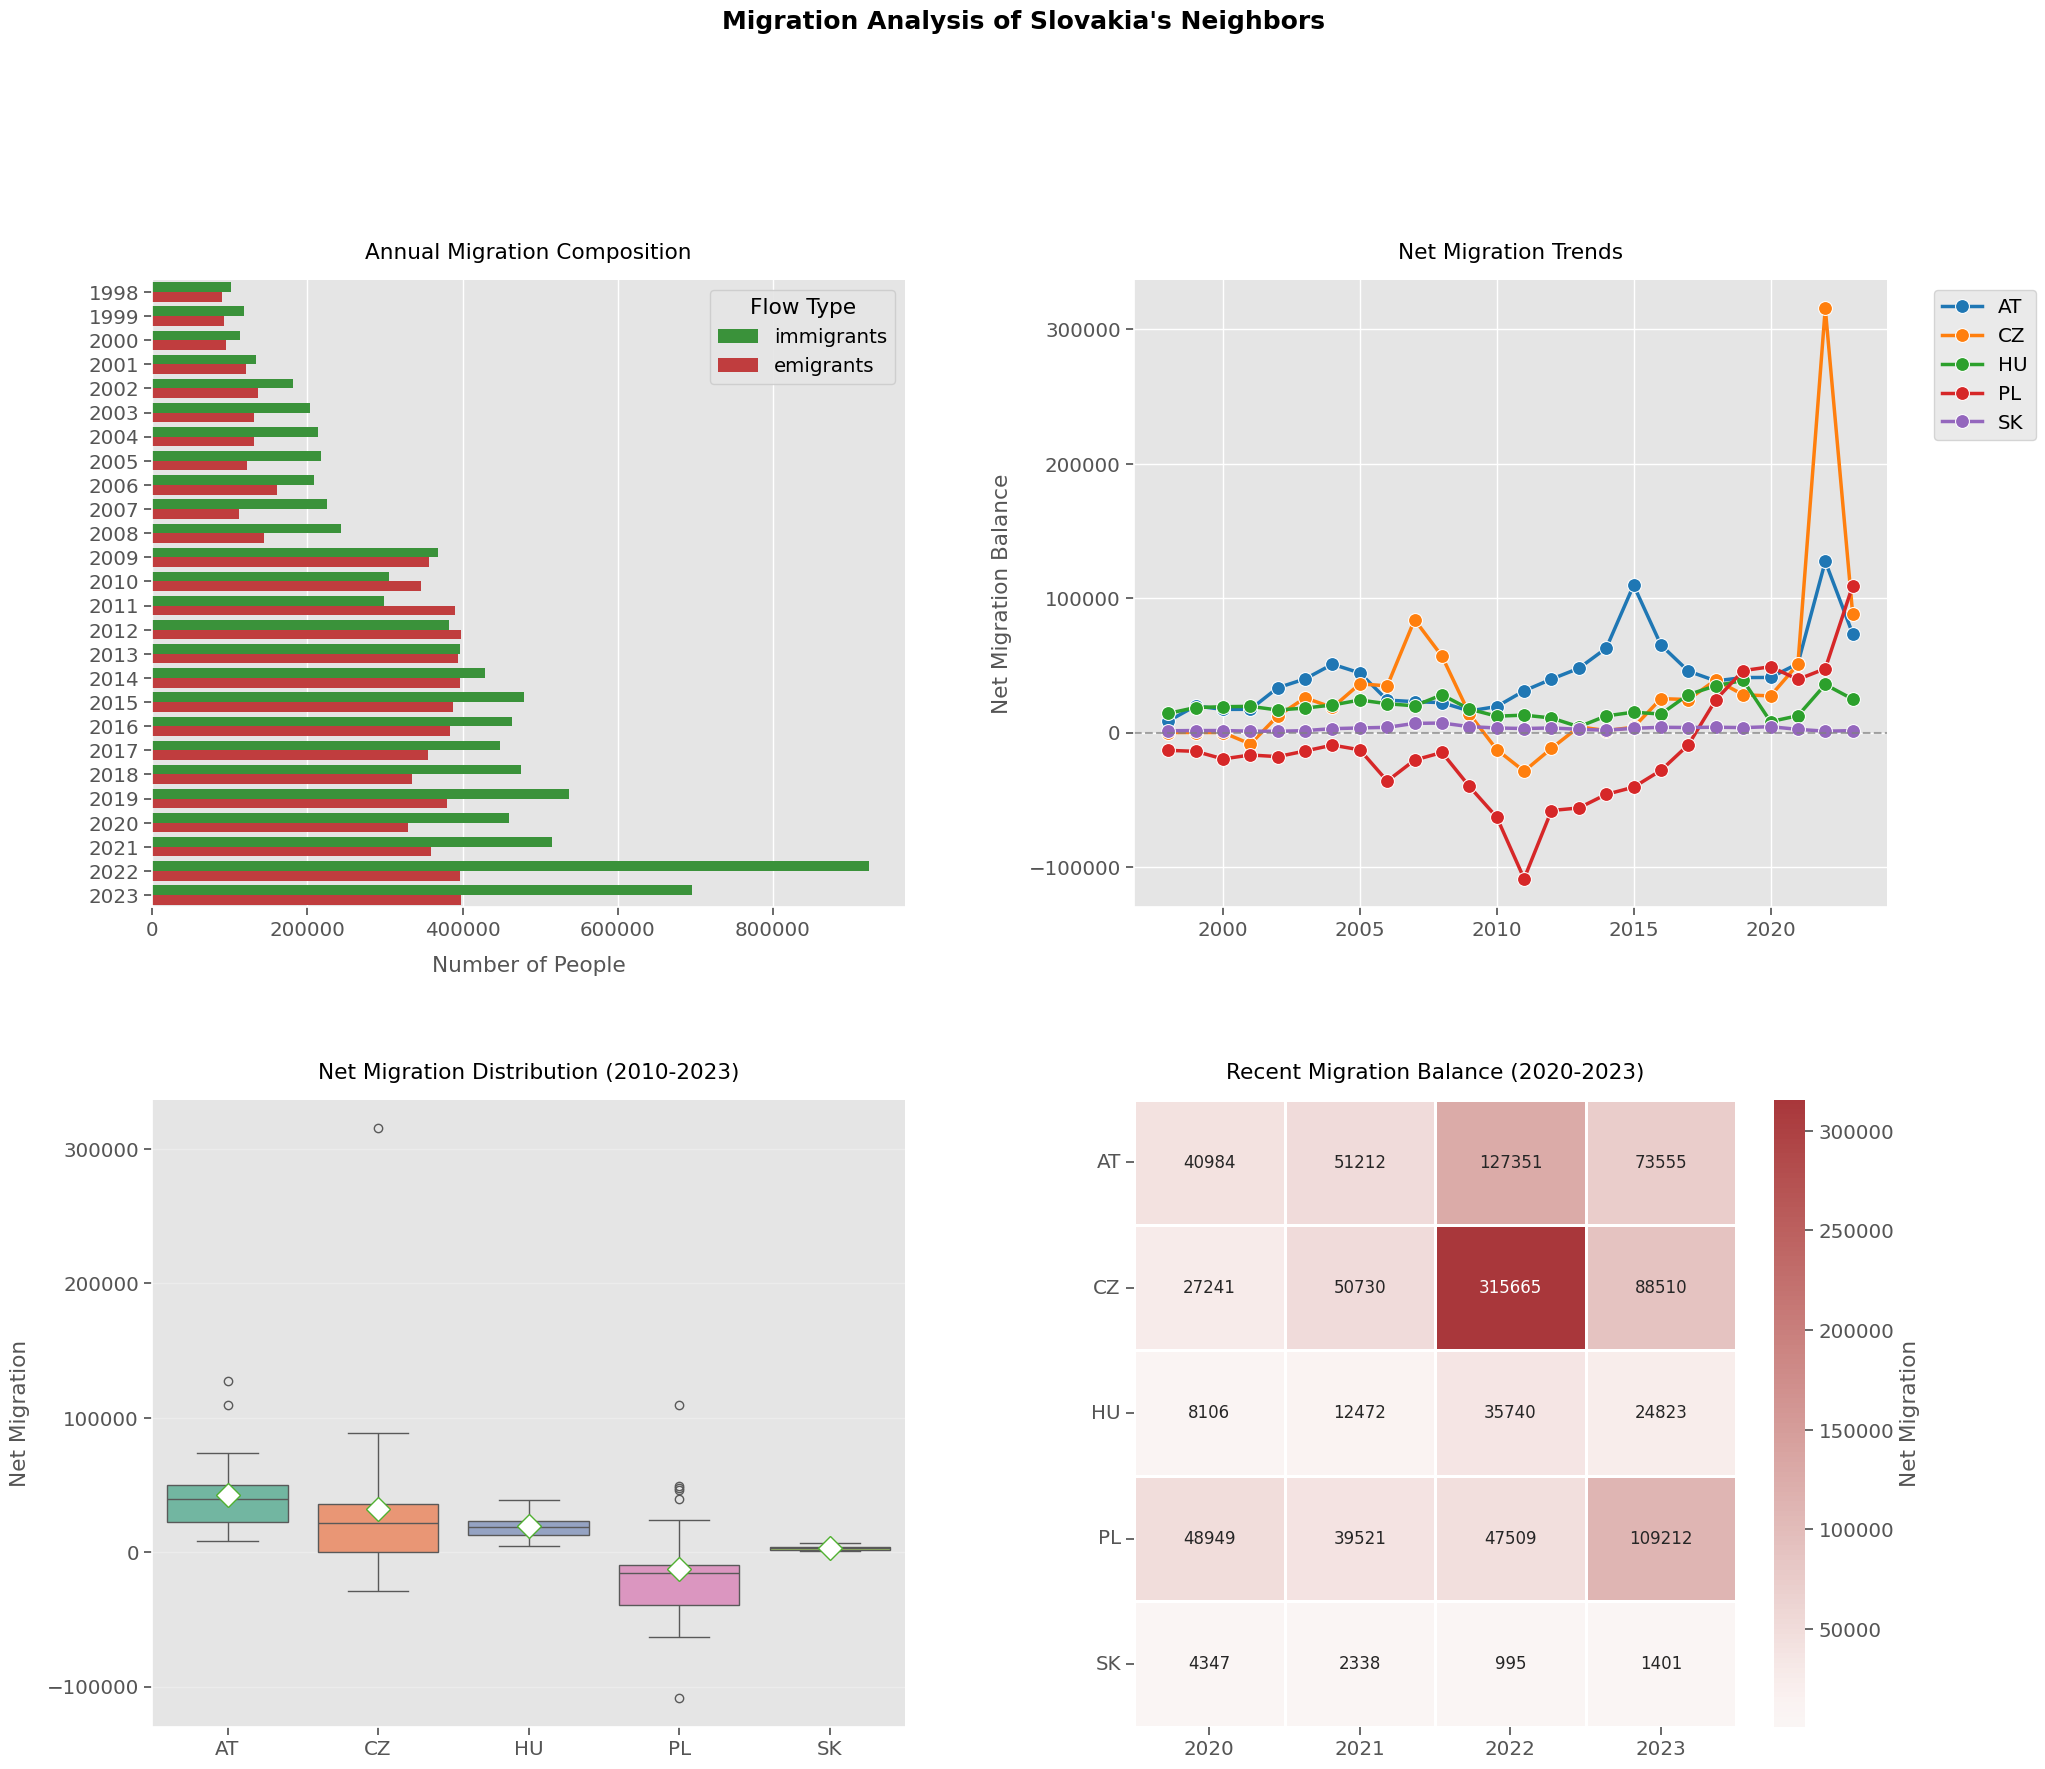

In [ ]:
### --- Migration Trends Analysis --- ###
def analyze_migration_trends(data):
    """
    Analyze migration patterns for Slovakia and its neighbors (SK, AT, HU, CZ, PL)
    Produces 4-panel visualization using seaborn
    """
    # Prepare data
    df = data.copy()
    # Calculate the balance between the number of immigrants and emigrants
    df['net_migration'] = df['immigrants'] - df['emigrants']
    df = df.dropna(subset=['net_migration'])

    # Visualization setup
    fig = plt.figure(figsize=(22, 18))
    plt.style.use('ggplot')
    sns.set_palette("husl")
    sns.set_context("notebook", font_scale=1.3)
    plt.suptitle("Migration Analysis of Slovakia's Neighbors", y=1.02, fontsize=18, weight='bold')

    # --- Panel 1: Migration Composition ---
    plt.subplot(2, 2, 1)
    melted = df.melt(
        id_vars=['country', 'year'],
        value_vars=['immigrants', 'emigrants'],
        var_name='type'
    )
    ax1 = sns.barplot(
        y='year',
        x='value',
        hue='type',
        data=melted,
        palette={'immigrants': '#2ca02c', 'emigrants': '#d62728'},
        errorbar=None,
        estimator='sum',
        orient='h'
    )
    plt.title('Annual Migration Composition', pad=15)
    plt.ylabel('', labelpad=12)
    plt.xlabel('Number of People', labelpad=12)
    plt.legend(title='Flow Type', frameon=True, loc='upper right',
              bbox_to_anchor=(1, 1), framealpha=0.9)
    sns.despine()

    # --- Panel 2: Net Migration Trends ---
    plt.subplot(2, 2, 2)
    ax2 = sns.lineplot(
        x='year',
        y='net_migration',
        hue='country',
        data=df,
        marker='o',
        markersize=10,
        linewidth=2.5,
        palette='tab10'
    )
    plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
    plt.title('Net Migration Trends', pad=15)
    plt.xlabel('', labelpad=12)
    plt.ylabel('Net Migration Balance', labelpad=12)
    plt.legend(frameon=True, bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine()

    # --- Panel 3: Country Comparison ---
    plt.subplot(2, 2, 3)
    ax3 = sns.boxplot(
        x='country',
        y='net_migration',
        hue='country',
        data=df,
        palette='Set2',
        showmeans=True,
        meanprops={"marker":"D", "markerfacecolor":"white", "markersize":"12"},
        legend=False
    )
    plt.title('Net Migration Distribution (2010-2023)', pad=15)
    plt.xlabel('', labelpad=12)
    plt.ylabel('Net Migration', labelpad=12)
    plt.xticks(ha='center')
    plt.grid(axis='y', alpha=0.3)
    sns.despine()

    # --- Panel 4: Recent Migration Heatmap ---
    plt.subplot(2, 2, 4)
    heatmap_data = df[df['year'] >= 2020].pivot_table(
        index='country',
        columns='year',
        values='net_migration'
    ).fillna(0)

    ax4 = sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".0f",
        cmap='vlag',
        center=0,
        linewidths=0.8,
        cbar_kws={'label': 'Net Migration'},
        annot_kws={'size': 12}
    )
    plt.title('Recent Migration Balance (2020-2023)', pad=15)
    plt.xlabel('', labelpad=12)
    plt.ylabel('', labelpad=12)
    plt.yticks(rotation=0)

    # Final adjustments
    plt.tight_layout(pad=4.0)
    plt.show()

    # Save figure
    fig_save(fig, 'img/migration_trends_analysis.png')

analyze_migration_trends(migration_data_sk_neighbors)

In [ ]:
display(ua_immigrants['country'].unique().tolist())

['AD',
 'AM',
 'AT',
 'AZ',
 'BA',
 'BE',
 'BG',
 'BY',
 'CH',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'EL',
 'ES',
 'EU27_2020',
 'FI',
 'FR',
 'HR',
 'HU',
 'IE',
 'IS',
 'IT',
 'KG',
 'LI',
 'LT',
 'LU',
 'LV',
 'MD',
 'ME',
 'MK',
 'MT',
 'NL',
 'NO',
 'PL',
 'PT',
 'RO',
 'RU',
 'SE',
 'SI',
 'SK',
 'SM',
 'TJ',
 'TR',
 'UA',
 'UK',
 'US',
 'UZ']

In [ ]:
def create_geo_plot(data):
    """
    Creates a choropleth map showing total Ukrainian immigrants by country.
    """
    # Aggregate total immigrants per country
    country_totals = (
        data.groupby(['country', 'sex'], as_index=False)
        .agg(total_immigrants=('immigrants', 'sum'))
        .query('sex == "T"')  # Use total sex category
    )

    # Filter out EU aggregates and non-country codes
    country_totals = country_totals[country_totals['country'] != 'EU27_2020']

    # Complete Eurostat to ISO Alpha-3 mapping
    country_code_mapping = {
        'AD': 'AND',  # Andorra
        'AM': 'ARM',  # Armenia
        'AT': 'AUT',  # Austria
        'AZ': 'AZE',  # Azerbaijan
        'BA': 'BIH',  # Bosnia and Herzegovina
        'BE': 'BEL',  # Belgium
        'BG': 'BGR',  # Bulgaria
        'BY': 'BLR',  # Belarus
        'CH': 'CHE',  # Switzerland
        'CY': 'CYP',  # Cyprus
        'CZ': 'CZE',  # Czechia
        'DE': 'DEU',  # Germany
        'DK': 'DNK',  # Denmark
        'EE': 'EST',  # Estonia
        'EL': 'GRC',  # Greece
        'ES': 'ESP',  # Spain
        'FI': 'FIN',  # Finland
        'FR': 'FRA',  # France
        'HR': 'HRV',  # Croatia
        'HU': 'HUN',  # Hungary
        'IE': 'IRL',  # Ireland
        'IS': 'ISL',  # Iceland
        'IT': 'ITA',  # Italy
        'KG': 'KGZ',  # Kyrgyzstan
        'LI': 'LIE',  # Liechtenstein
        'LT': 'LTU',  # Lithuania
        'LU': 'LUX',  # Luxembourg
        'LV': 'LVA',  # Latvia
        'MD': 'MDA',  # Moldova
        'ME': 'MNE',  # Montenegro
        'MK': 'MKD',  # North Macedonia
        'MT': 'MLT',  # Malta
        'NL': 'NLD',  # Netherlands
        'NO': 'NOR',  # Norway
        'PL': 'POL',  # Poland
        'PT': 'PRT',  # Portugal
        'RO': 'ROU',  # Romania
        'RU': 'RUS',  # Russia
        'SE': 'SWE',  # Sweden
        'SI': 'SVN',  # Slovenia
        'SK': 'SVK',  # Slovakia
        'SM': 'SMR',  # San Marino
        'TJ': 'TJK',  # Tajikistan
        'TR': 'TUR',  # Turkey
        'UA': 'UKR',  # Ukraine
        'UK': 'GBR',  # United Kingdom
        'US': 'USA',  # United States
        'UZ': 'UZB'   # Uzbekistan
    }

    # Add ISO codes and clean data
    country_totals['iso_alpha'] = country_totals['country'].map(country_code_mapping)
    country_totals = country_totals.dropna(subset=['iso_alpha'])

    # Create choropleth map
    fig = px.choropleth(
        country_totals,
        locations='iso_alpha',
        color='total_immigrants',
        hover_name='country',
        hover_data={'iso_alpha': False, 'sex': False},
        color_continuous_scale=px.colors.sequential.Plasma,
        projection='natural earth',
        title='Ukrainian Immigration by Country (Total)',
        labels={'total_immigrants': 'Ukrainian Immigrants'}
    )

    # Customize layout
    fig.update_layout(
        margin={"r": 0, "t": 40, "l": 0, "b": 0},
        coloraxis_colorbar=dict(
            title="Immigrants",
            thickness=20,
            len=0.75
        )
    )

    # Show and save the plot
    fig.show()
    fig.write_image("img/ua_immigration_map.png", scale=2, width=1200, height=800)

create_geo_plot(ua_immigrants)

In [ ]:
def create_refugee_map(data):
    """
    Creates a choropleth map showing Ukrainian refugee displacement by country.
    """
    # Aggregate total refugees per asylum country
    country_totals = (
        data.groupby(['asylum_country', 'asylum_country_iso'], as_index=False)
        .agg(total_refugees=('refugees', 'sum'))
    )

    # Create choropleth map
    fig = px.choropleth(
        country_totals,
        locations='asylum_country_iso',
        color='total_refugees',
        hover_name='asylum_country',
        hover_data={'asylum_country_iso': False},
        color_continuous_scale=px.colors.sequential.Plasma,
        projection='natural earth',
        title='Ukrainian Refugee Displacement by Country (Total)',
        labels={'total_refugees': 'Refugees from Ukraine'},
        scope='world'
    )

    # Customize layout
    fig.update_layout(
        margin={"r": 0, "t": 40, "l": 0, "b": 0},
        coloraxis_colorbar=dict(
            title="Refugees",
            thickness=20,
            len=0.75
        )
    )

    # Show and save the plot
    fig.show()
    fig.write_image('img/ukrainian_refugee_map.png', scale=2, width=1200, height=800)

create_refugee_map(ua_displacement_cleaned)

In [ ]:
def plot_top_refugee_countries(data):
    """
    Creates a horizontal bar plot of top 10 countries by refugee count.
    """
    # Aggregate and sort data
    top_countries = (
        data.groupby(['asylum_country', 'asylum_country_iso'], as_index=False)
        .agg(total_refugees=('refugees', 'sum'))
        .sort_values('total_refugees', ascending=False)
        .head(10)
        .sort_values('total_refugees', ascending=True)
    )

    # Create plot with SI formatting
    fig = px.bar(
        top_countries,
        x='total_refugees',
        y='asylum_country',
        orientation='h',
        text='total_refugees',
        hover_data={'asylum_country_iso': True, 'total_refugees': ':,', 'asylum_country': False},
        color='total_refugees',
        color_continuous_scale=px.colors.sequential.Plasma,
        title='Top 10 Countries Hosting Ukrainian Refugees',
        labels={'total_refugees': 'Number of Refugees', 'asylum_country': ''}
    )

    # Customize layout
    max_refugees = top_countries['total_refugees'].max()
    fig.update_layout(
        margin={"r": 200, "t": 60, "l": 150, "b": 40},
        coloraxis_showscale=False,
        yaxis={'categoryorder': 'total ascending'},
        xaxis={
            'showgrid': True,
            'ticksuffix': ' ',
            'tickformat': '~s',
            'range': [0, max_refugees * 1.15]
        },
        hoverlabel={'bgcolor': 'white'}
    )

    # Format numbers and text
    fig.update_traces(
        texttemplate='%{text:~s}',
        textposition='outside',
        textfont_size=12,
        hovertemplate='<b>%{y}</b> (%{customdata[0]})<br>Refugees: %{x:,}<extra></extra>',
        textfont_color='black'
    )

    # Save and show
    fig.show()
    fig.write_image('img/top_10_refugee_countries.png',
                   scale=2,
                   width=1600,
                   height=800)

plot_top_refugee_countries(ua_displacement_cleaned)

In [ ]:
def plot_top_returned_refugees(data):
    """
    Creates a horizontal bar plot of top 10 countries by returned refugee count.
    """
    # Aggregate and sort return data
    data = data.copy(deep=True)[~data['asylum_country_iso'].isin(['UNK'])]

    top_countries = (
        data.groupby(['asylum_country', 'asylum_country_iso'], as_index=False)
        .agg(total_returns=('returned_refugees', 'sum'))
        .sort_values('total_returns', ascending=False)
        .head(10)
        .sort_values('total_returns', ascending=True)
    )

    # Create plot with SI formatting
    fig = px.bar(
        top_countries,
        x='total_returns',
        y='asylum_country',
        orientation='h',
        text='total_returns',
        hover_data={'asylum_country_iso': True, 'total_returns': ':,', 'asylum_country': False},
        color='total_returns',
        color_continuous_scale=px.colors.sequential.Plasma,
        title='Top 10 Countries with Returning Ukrainian Refugees',
        labels={'total_returns': 'Number of Returned Refugees', 'asylum_country': ''}
    )

    # Customize layout
    max_returns = top_countries['total_returns'].max()
    fig.update_layout(
        margin={"r": 200, "t": 60, "l": 150, "b": 40},
        coloraxis_showscale=False,
        yaxis={'categoryorder': 'total ascending'},
        xaxis={
            'showgrid': True,
            'ticksuffix': ' ',
            'tickformat': '~s',
            'range': [0, max_returns * 1.15]
        },
        hoverlabel={'bgcolor': 'white'}
    )

    # Format numbers and text
    fig.update_traces(
        texttemplate='%{text:~s}',
        textposition='outside',
        textfont_size=12,
        hovertemplate='<b>%{y}</b> (%{customdata[0]})<br>Returned Refugees: %{x:,}<extra></extra>',
        textfont_color='black'
    )

    # Save and show
    fig.show()
    fig.write_image('img/top_10_returned_refugees.png',
                   scale=2,
                   width=1600,
                   height=800)

plot_top_returned_refugees(ua_displacement_cleaned)

In [ ]:
def plot_top_refugee_countries(data):
    """
    Creates a horizontal bar plot of top 10 EU countries by refugee count.
    """
    # Aggregate and sort data
    data = data.copy(deep=True)[~data['asylum_country_iso'].isin(['RUS', 'GBR', 'MDA'])]

    top_countries = (
        data.groupby(['asylum_country', 'asylum_country_iso'], as_index=False)
        .agg(total_refugees=('refugees', 'sum'))
        .sort_values('total_refugees', ascending=False)
        .head(10)
        .sort_values('total_refugees', ascending=True)
        .replace({'asylum_country': {'Netherlands (Kingdom of the)': 'Netherlands'}})
    )

    # Create plot with SI formatting
    fig = px.bar(
        top_countries,
        x='total_refugees',
        y='asylum_country',
        orientation='h',
        text='total_refugees',
        hover_data={'asylum_country_iso': True, 'total_refugees': ':,', 'asylum_country': False},
        title='Top 10 EU Countries Hosting Ukrainian Refugees',
        labels={'total_refugees': 'Number of Refugees', 'asylum_country': ''}
    )

    # Customize layout
    max_refugees = top_countries['total_refugees'].max()
    fig.update_layout(
        margin={"r": 200, "t": 60, "l": 150, "b": 40},
        coloraxis_showscale=False,
        yaxis={'categoryorder': 'total ascending'},
        xaxis={
            'showgrid': True,
            'ticksuffix': ' ',
            'tickformat': '~s',
            'range': [0, max_refugees * 1.15]
        },
        hoverlabel={'bgcolor': 'white'}
    )

    # Format numbers and text
    fig.update_traces(
        texttemplate='%{text:~s}',
        textposition='outside',
        textfont_size=12,
        hovertemplate='<b>%{y}</b> (%{customdata[0]})<br>Refugees: %{x:,}<extra></extra>',
        textfont_color='black'
    )

    # Save and show
    fig.show()
    fig.write_image('img/top_10_EU_refugee_countries.png',
                   scale=2,
                   width=1600,
                   height=800)

plot_top_refugee_countries(ua_displacement_cleaned)

In [ ]:
def plot_top_immigrant_countries(data):
    """
    Creates a horizontal bar plot of top 10 EU countries by Ukrainian immigrant count.
    """
    # Aggregate and sort data

    data = data.copy(deep=True).query('sex == "T"').drop(columns=['sex'])
    data = data[~data['country'].isin(['MD'])]

    top_countries = (
        data.groupby(['country'], as_index=False)
        .agg(total_immigrants=('immigrants', 'sum'))
        .sort_values('total_immigrants', ascending=False)
        .head(10)
        .sort_values('total_immigrants', ascending=True)
    )

    country_name_map = {
        'AT': 'Austria',
        'CZ': 'Czech Republic',
        'DE': 'Germany',
        'ES': 'Spain',
        'HU': 'Hungary',
        'IT': 'Italy',
        'LT': 'Lithuania',
        'NL': 'Netherlands',
        'NO': 'Norway',
        'RO': 'Romania'
    }

    top_countries['country'] = top_countries['country'].map(country_name_map)

    # Create plot with SI formatting
    fig = px.bar(
        top_countries,
        x='total_immigrants',
        y='country',
        orientation='h',
        text='total_immigrants',
        hover_data={'total_immigrants': ':,'},
        title='Top 10 EU Countries Hosting Ukrainian Immigrants',
        labels={'total_immigrants': 'Number of Immigrants', 'country': ''}
    )


    # Customize layout
    max_immigrants = top_countries['total_immigrants'].max()
    fig.update_layout(
        margin={"r": 200, "t": 60, "l": 150, "b": 40},
        coloraxis_showscale=False,
        yaxis={'categoryorder': 'total ascending'},
        xaxis={
            'showgrid': True,
            'ticksuffix': ' ',
            'tickformat': '~s',
            'range': [0, max_immigrants * 1.15]
        },
        hoverlabel={'bgcolor': 'white'}
    )

    # Format numbers and text
    fig.update_traces(
        texttemplate='%{text:~s}',
        textposition='outside',
        textfont_size=12,
        hovertemplate='<b>%{y}</b><br>Immigrants: %{x:,}<extra></extra>',
        textfont_color='black'
    )

    # Save and show
    fig.show()
    fig.write_image('img/top_10_EU_immigrant_countries.png',
                   scale=2,
                   width=1600,
                   height=800)

plot_top_immigrant_countries(ua_immigrants)

In [ ]:
display(ua_immigrants.query('country == "DE"'))

,country,sex,year,immigrants
858,DE,F,1998,16182.0
859,DE,F,1999,17992.0
860,DE,F,2000,0.0
861,DE,F,2001,24580.0
862,DE,F,2002,25436.0
...,...,...,...,...
931,DE,T,2019,17768.0
932,DE,T,2020,16944.0
933,DE,T,2021,22900.0
934,DE,T,2022,1887600.0


In [ ]:
def plot_asylum_seekers_distribution(data):
    """
    Creates a pie chart showing distribution of Ukrainian asylum seekers by country.
    """
    # Aggregate total asylum seekers per country
    country_data = (
        data.groupby('asylum_country', as_index=False)
        .agg(total_asylum_seekers=('asylum_seekers', 'sum'))
        .sort_values('total_asylum_seekers', ascending=False)
    )

    # Calculate percentages and create labels
    total = country_data['total_asylum_seekers'].sum()
    country_data['percentage'] = country_data['total_asylum_seekers'] / total

    # Create "Other" category for countries < 2%
    threshold = 0.02
    main_countries = country_data[country_data['percentage'] >= threshold]
    other = pd.DataFrame([{
        'asylum_country': 'Other Countries',
        'total_asylum_seekers': country_data[country_data['percentage'] < threshold]['total_asylum_seekers'].sum(),
        'percentage': country_data[country_data['percentage'] < threshold]['percentage'].sum()
    }])

    plot_data = pd.concat([main_countries, other])

    # Create pie chart
    fig = px.pie(
        plot_data,
        values='total_asylum_seekers',
        names='asylum_country',
        title='Distribution of Ukrainian Asylum Seekers',
        color_discrete_sequence=px.colors.sequential.Plasma,
        hole=0.3,
        labels={'total_asylum_seekers': 'Asylum Seekers'},
        hover_data={'percentage': ':.1%'}
    )

    # Customize layout
    fig.update_traces(
        textposition='inside',
        texttemplate='%{label}<br>%{percent:.1%}',
        textfont_size=14,
        textfont_color='white',
        marker=dict(line=dict(color='#000000', width=0.3)),
        rotation=40
    )

    fig.update_layout(
        # Increased overall size and adjusted margins
        width=1000,
        height=800,
        margin=dict(t=100, b=50, l=50, r=5),
        legend=dict(
            title='Countries',
            orientation='v',
            yanchor='middle',
            y=0.5,
            x=1.05,
            xanchor='left',
            font=dict(size=12),  # Legend font size
            itemsizing='constant'  # Consistent legend item sizes
        ),
        annotations=[dict(
            text=f"Total: {total:,}",
            x=0.5, y=0.5,
            font_size=18,  # Total text size
            showarrow=False
        )]
    )

    fig.show()
    # Save figure
    fig.write_image('img/ua_asylum_seekers_distribution.png',
                   scale=3,
                   width=1000,
                   height=800)


plot_asylum_seekers_distribution(ua_displacement_cleaned)

In [ ]:
def plot_global_trend(data):
    """
    Shows worldwide asylum seekers trend over time.
    """
    # Aggregate global totals
    global_data = data.groupby('year', as_index=False).agg(
        total=('total_asylum_seekers', 'sum')
    )

    # Create interactive time series
    fig = px.line(
        global_data,
        x='year',
        y='total',
        markers=True,
        title='Global Asylum Seekers Trend',
        labels={'total': 'Number of Asylum Seekers', 'year': ''},
        template='plotly_white'
    )

    # Add confidence band using quartiles
    fig.add_trace(go.Scatter(
        x=global_data['year'],
        y=global_data['total'] * 1.1,
        fill='tonexty',
        fillcolor='rgba(100, 80, 150, 0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        hoverinfo='skip'
    ))

    # Customize layout
    fig.update_layout(
        hovermode='x unified',
        xaxis=dict(tickmode='linear'),
        yaxis=dict(
            rangemode='tozero',
            tickformat=',',
            title='Total Asylum Seekers'
        ),
        margin=dict(t=40, b=40),
        height=500
    )

    fig.write_image('img/global_asylum_trend.png', scale=2)
    fig.show()

plot_global_trend(asylum_eurostat_cleaned)

In [ ]:
def plot_ua_global_trend(data):
    """
    Shows worldwide Ukrainian immigrant trend over time. Log scale.
    """
    # Aggregate totals by year
    global_data = (
        data
        .query('sex == "T"')
        .drop(columns=['sex'])
        .groupby('year', as_index=False)
        .agg(total=('immigrants', 'sum'))
    )

    # Create line chart
    fig = px.line(
        global_data,
        x='year',
        y='total',
        log_y=True,
        markers=True,
        title='Global Trend of Ukrainian Immigrants Over Time (Log Scale)',
        labels={'total': 'Number of Ukrainian Immigrants', 'year': ''},
        template='plotly_white'
    )

    # Add visual confidence band
    fig.add_trace(go.Scatter(
        x=global_data['year'],
        y=global_data['total'] * 1.1,
        fill='tonexty',
        fillcolor='rgba(0, 100, 200, 0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        hoverinfo='skip'
    ))

    # Layout tweaks
    fig.update_layout(
        hovermode='x unified',
        xaxis=dict(tickmode='linear'),
        yaxis=dict(
            rangemode='tozero',
            tickformat=',',
            title='Total Ukrainian Immigrants',
            tickvals=[20000, 50000, 100000, 200000, 500000, 1000000, 2000000, 3000000, 4000000, 5000000]
        ),
        margin=dict(t=40, b=40),
        height=500
    )

    fig.write_image('img/global_ua_immigrant_trend.png', scale=2)
    fig.show()

plot_ua_global_trend(ua_immigrants)

In [ ]:
def plot_country_distributions(data):
    """
    Creates violin plots showing distribution of asylum seekers for top 5 countries.
    """
    # Get top 5 countries by total asylum seekers and other countries
    country_totals = (
        data.groupby('country')['total_asylum_seekers']
        .sum()
        .reset_index(name='total')
        .nlargest(6, 'total')
    )
    top_countries = country_totals['country'].tolist()
    filtered_data = data[data['country'].isin(top_countries)]

    # Create enhanced violin plot
    fig = px.violin(
        filtered_data,
        x='country',
        y='total_asylum_seekers',
        color='country',
        box=True,
        points="all",
        hover_data=['year'],
        title='Asylum Seekers Distribution in Top 5 Countries',
        labels={'total_asylum_seekers': 'Asylum Seekers', 'country': ''},
        color_discrete_sequence=px.colors.qualitative.Pastel,
        log_y=True
    )

    # Customize layout
    fig.update_layout(
        xaxis=dict(
            showgrid=False,
            title='',
        ),
        yaxis=dict(
            title='Asylum Seekers (log scale)',
            tickformat=',',
            gridcolor='rgba(200, 200, 200, 0.2)'
        ),
        height=600,
        width=1000,
        margin=dict(t=80, b=120, l=80, r=40),
        showlegend=False,
        hoverlabel=dict(
            bgcolor='white',
            font_size=12
        )
    )

    # Add custom hover template
    fig.update_traces(
        hovertemplate="<b>%{x}</b><br>Year: %{customdata[0]}<br>Asylum Seekers: %{y:,}"
    )

    # Add annotation for log scale note
    fig.add_annotation(
        x=0.5,
        y=-0.3,
        xref='paper',
        yref='paper',
        text="Note: Y-axis uses logarithmic scale for better visualization of distribution",
        showarrow=False,
        font=dict(size=10, color='gray')
    )

    fig.write_image('img/asylum_country_distributions.png', scale=2)
    fig.show()


plot_country_distributions(asylum_eurostat_cleaned)

/home/rokki/.venv/datavis/lib/python3.13/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

